In [27]:
#import all using packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gp
import pygeos
import rtree
from time import sleep
import requests
from fiona import BytesCollection  
from tobler.area_weighted import area_interpolate
from tobler.dasymetric import masked_area_interpolate
from shapely.geometry import Point, Polygon

# Import the data

**Plännungsräume Geodataframe(plr_gdf)**
- 542 Plännungsräume
- 10 columns with 'PLR_ID', 'PLR_NAME', 'BZR_ID', 'BZR_NAME', 'PGR_ID', 'PGR_NAME', 'BEZ','FINHALT', 'STAND', 'geometry'

**Features extracted from OpenstreetMap**
were save in 13 csv.files containing Lad-, Longtitute coordinator
- mobility_public_transport.csv --> 15109 spots
- mobility_bike_infraestructure.csv
- mobility_bikepaths.csv
- spaces_green.csv
- spaces_water.csv
- social_community.csv
- social_culture.csv
- social_eating.csv
- social_night_life.csv
- activities_economic.csv
- activities_education.csv
- activities_health_care.csv
- activities_public_service.csv


**Area units in Berlin:** 
- Bezirk (12)
- Prognoseraum (60) → housing Data (price, etc.)
- Plannungsräume (449 until 2021 / 542 from 2021) → Level we are working (542)
- Blocks (25000)



In [185]:
#import the geodata of the new Plannungsräume
plr_gdf = gp.GeoDataFrame.from_file('../raw_data/Maps/pr_2021.shp')
plr_gdf.head()

PLR_ID                  PLR_NAME  BZR_ID                  BZR_NAME  \
0  11501341            Karlshorst Süd  115013                Karlshorst   
1  03701659       Immanuelkirchstraße  037016       Prenzlauer Berg Süd   
2  07601340  Tirschenreuther Ring Ost  076013           Marienfelde Süd   
3  02500831               Wismarplatz  025008  Frankfurter Allee Süd FK   
4  12601134        Märkisches Zentrum  126011                   MV Nord   

  PGR_ID                   PGR_NAME BEZ       FINHALT       STAND  \
0   1150            Lichtenberg Süd  11  2.294054e+06  01.01.2021   
1   0370  Südlicher Prenzlauer Berg  03  4.115167e+05  01.12.2021   
2   0760  Marienfelde / Lichtenrade  07  4.139754e+05  01.01.2021   
3   0250         Friedrichshain Ost  02  2.489918e+05  01.01.2021   
4   1260         Märkisches Viertel  12  1.127871e+06  01.01.2021   

                                            geometry  
0  POLYGON ((399848.954 5815619.506, 399854.727 5...  
1  POLYGON ((393175.012 5821135.577, 393167.174 5...  
2  POLYGON ((388394.110 5807792.070, 388379.276 5...  
3  POLYGON ((396010.552 5819339.570, 396021.567 5...  
4  POLYGON ((387367.428 5828619.763, 387315.862 5...

In [188]:
plr_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 542 entries, 0 to 541
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   PLR_ID    542 non-null    object  
 1   PLR_NAME  542 non-null    object  
 2   BZR_ID    542 non-null    object  
 3   BZR_NAME  542 non-null    object  
 4   PGR_ID    542 non-null    object  
 5   PGR_NAME  542 non-null    object  
 6   BEZ       542 non-null    object  
 7   FINHALT   542 non-null    float64 
 8   STAND     542 non-null    object  
 9   geometry  542 non-null    geometry
dtypes: float64(1), geometry(1), object(8)
memory usage: 42.5+ KB


<AxesSubplot:>

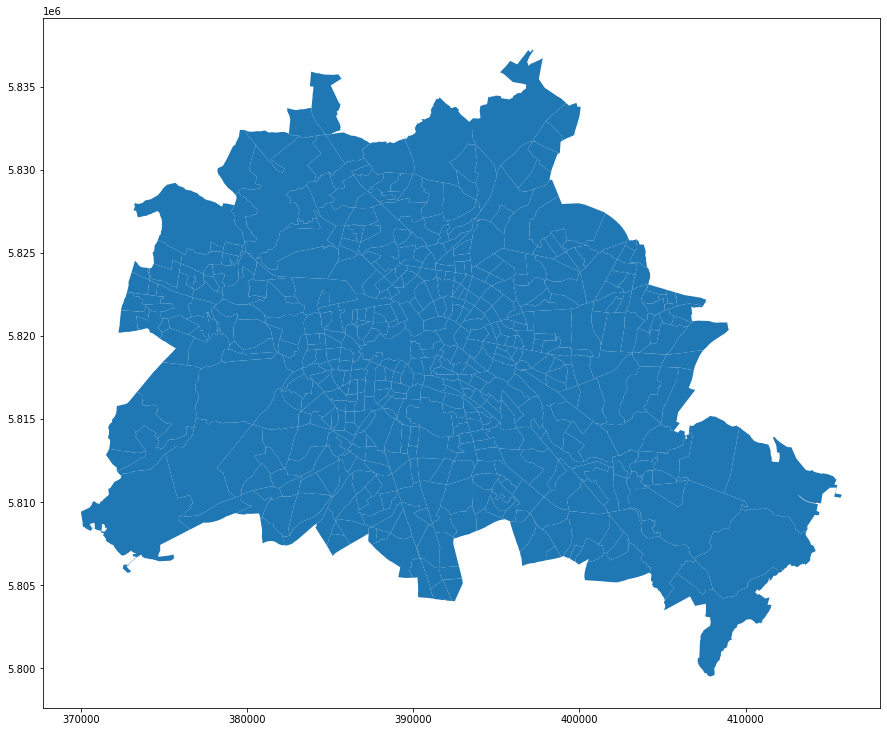

In [189]:
plr_gdf.plot(figsize=(15,15))


In [306]:
def features_plr(filename):
    """Convert csv file containing lat and lon gitude columns into geodata, sort into Plännungsräumen (plr),
    save the geodataframe in the shp file, and the datafrme with features-amount per plr in csv file"""
    
    path = f"../raw_data/OpenStreetMaps Feature/{filename}.csv"
    df = pd.read_csv(path)
    df = gp.GeoDataFrame(df, geometry=gp.points_from_xy(df.lon, df.lat), crs='epsg:4326')
    df = df[(df.lat>50) & (df.lon > 12)] #filtered the correct lat and lon
    df.to_crs(crs='epsg:25833', inplace=True) #change the crs system 
    plr_gdf = gp.GeoDataFrame.from_file('../raw_data/Maps/pr_2021.shp') #import geodataframe of plr
    nearest = df.sjoin_nearest(plr_gdf, how="left") #merged the features in 542 plr, by "nearest" spatial join
    amount = nearest.groupby(by='PLR_ID').size().reset_index() #created df contains feature-amount per plr
    amount.rename(columns={0:f"{filename}_amount"}, inplace=True)
    #save files in shp and csv
    nearest.to_file(f"../raw_data/FeaturesOnMap/{filename}.shp")
    amount.to_csv(f"../raw_data/FeaturesOnMap/{filename}.csv")
    #plot
    fig, ax = plt.subplots(figsize=(30,30))
    plr_gdf.plot(ax=ax, cmap="Pastel2", linewidth=2, column="PLR_NAME")
    fig.suptitle(f"{filename}_amount in Berlin-Plännungsräumen", fontsize=30)
    return nearest.plot(ax=ax, markersize=1)

/var/folders/n9/s2d67hcd6m30qbm0pf_jfqy00000gn/T/ipykernel_16491/2899947353.py:15: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  nearest.to_file(f"../raw_data/FeaturesOnMap/{filename}.shp")


<AxesSubplot:>

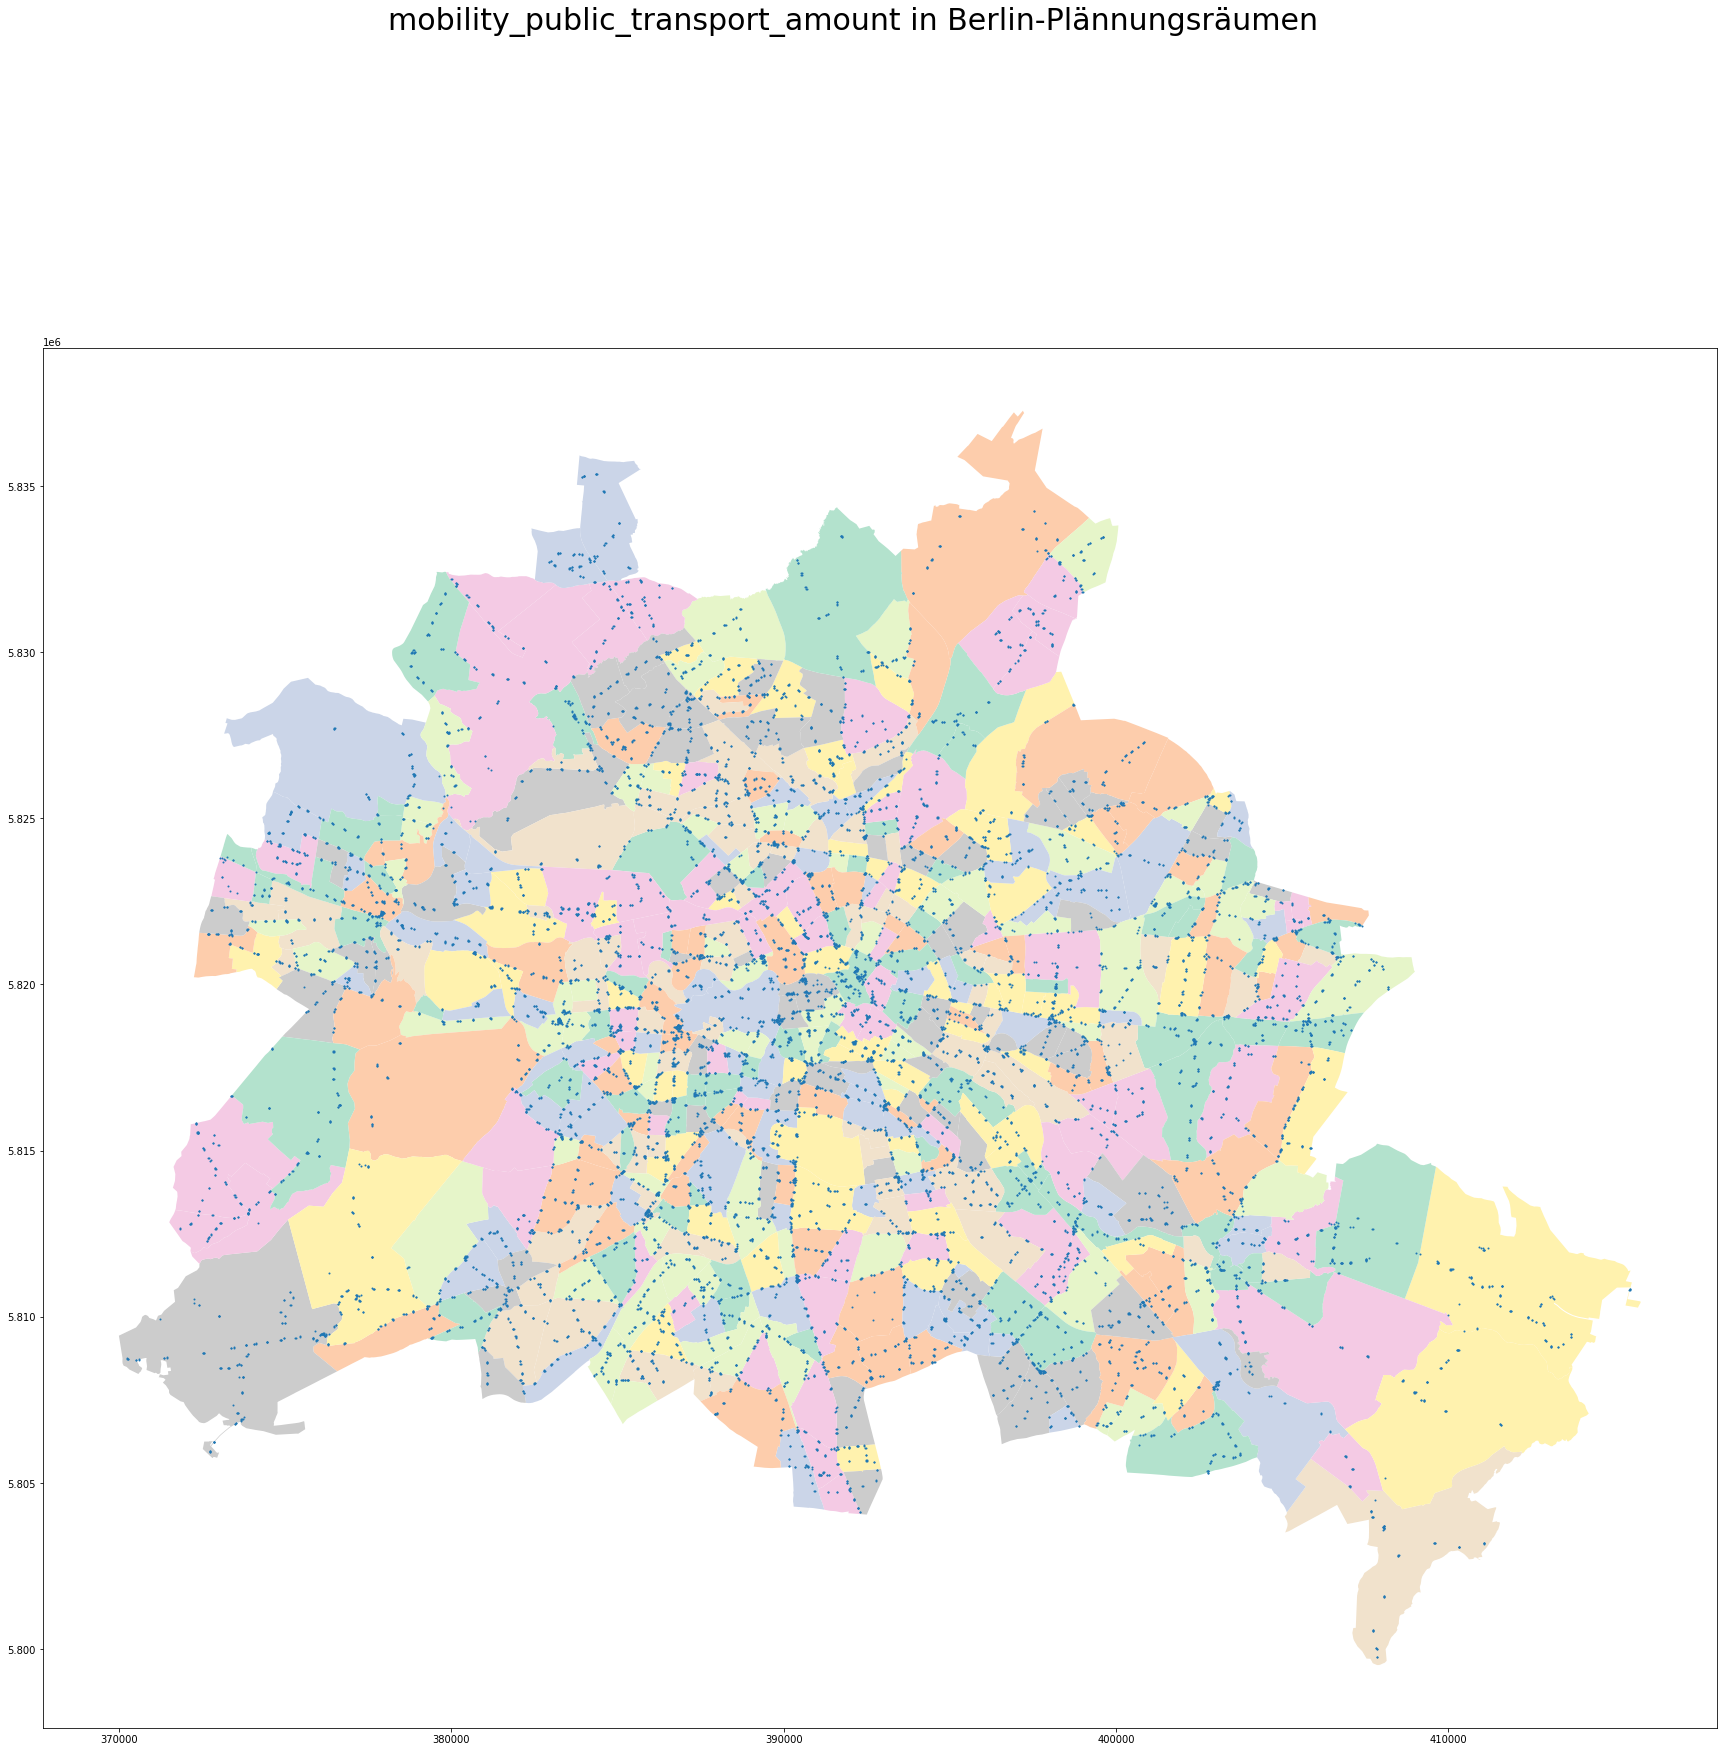

In [307]:
features_plr("mobility_public_transport")

/var/folders/n9/s2d67hcd6m30qbm0pf_jfqy00000gn/T/ipykernel_16491/2432317505.py:15: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  nearest.to_file(f"../raw_data/FeaturesOnMap/{filename}.shp")
/var/folders/n9/s2d67hcd6m30qbm0pf_jfqy00000gn/T/ipykernel_16491/2432317505.py:15: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  nearest.to_file(f"../raw_data/FeaturesOnMap/{filename}.shp")
/var/folders/n9/s2d67hcd6m30qbm0pf_jfqy00000gn/T/ipykernel_16491/2432317505.py:15: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  nearest.to_file(f"../raw_data/FeaturesOnMap/{filename}.shp")
/var/folders/n9/s2d67hcd6m30qbm0pf_jfqy00000gn/T/ipykernel_16491/2432317505.py:15: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  nearest.to_file(f"../raw_data/FeaturesOnMap/{filename}.shp")
/var/folders/n9/

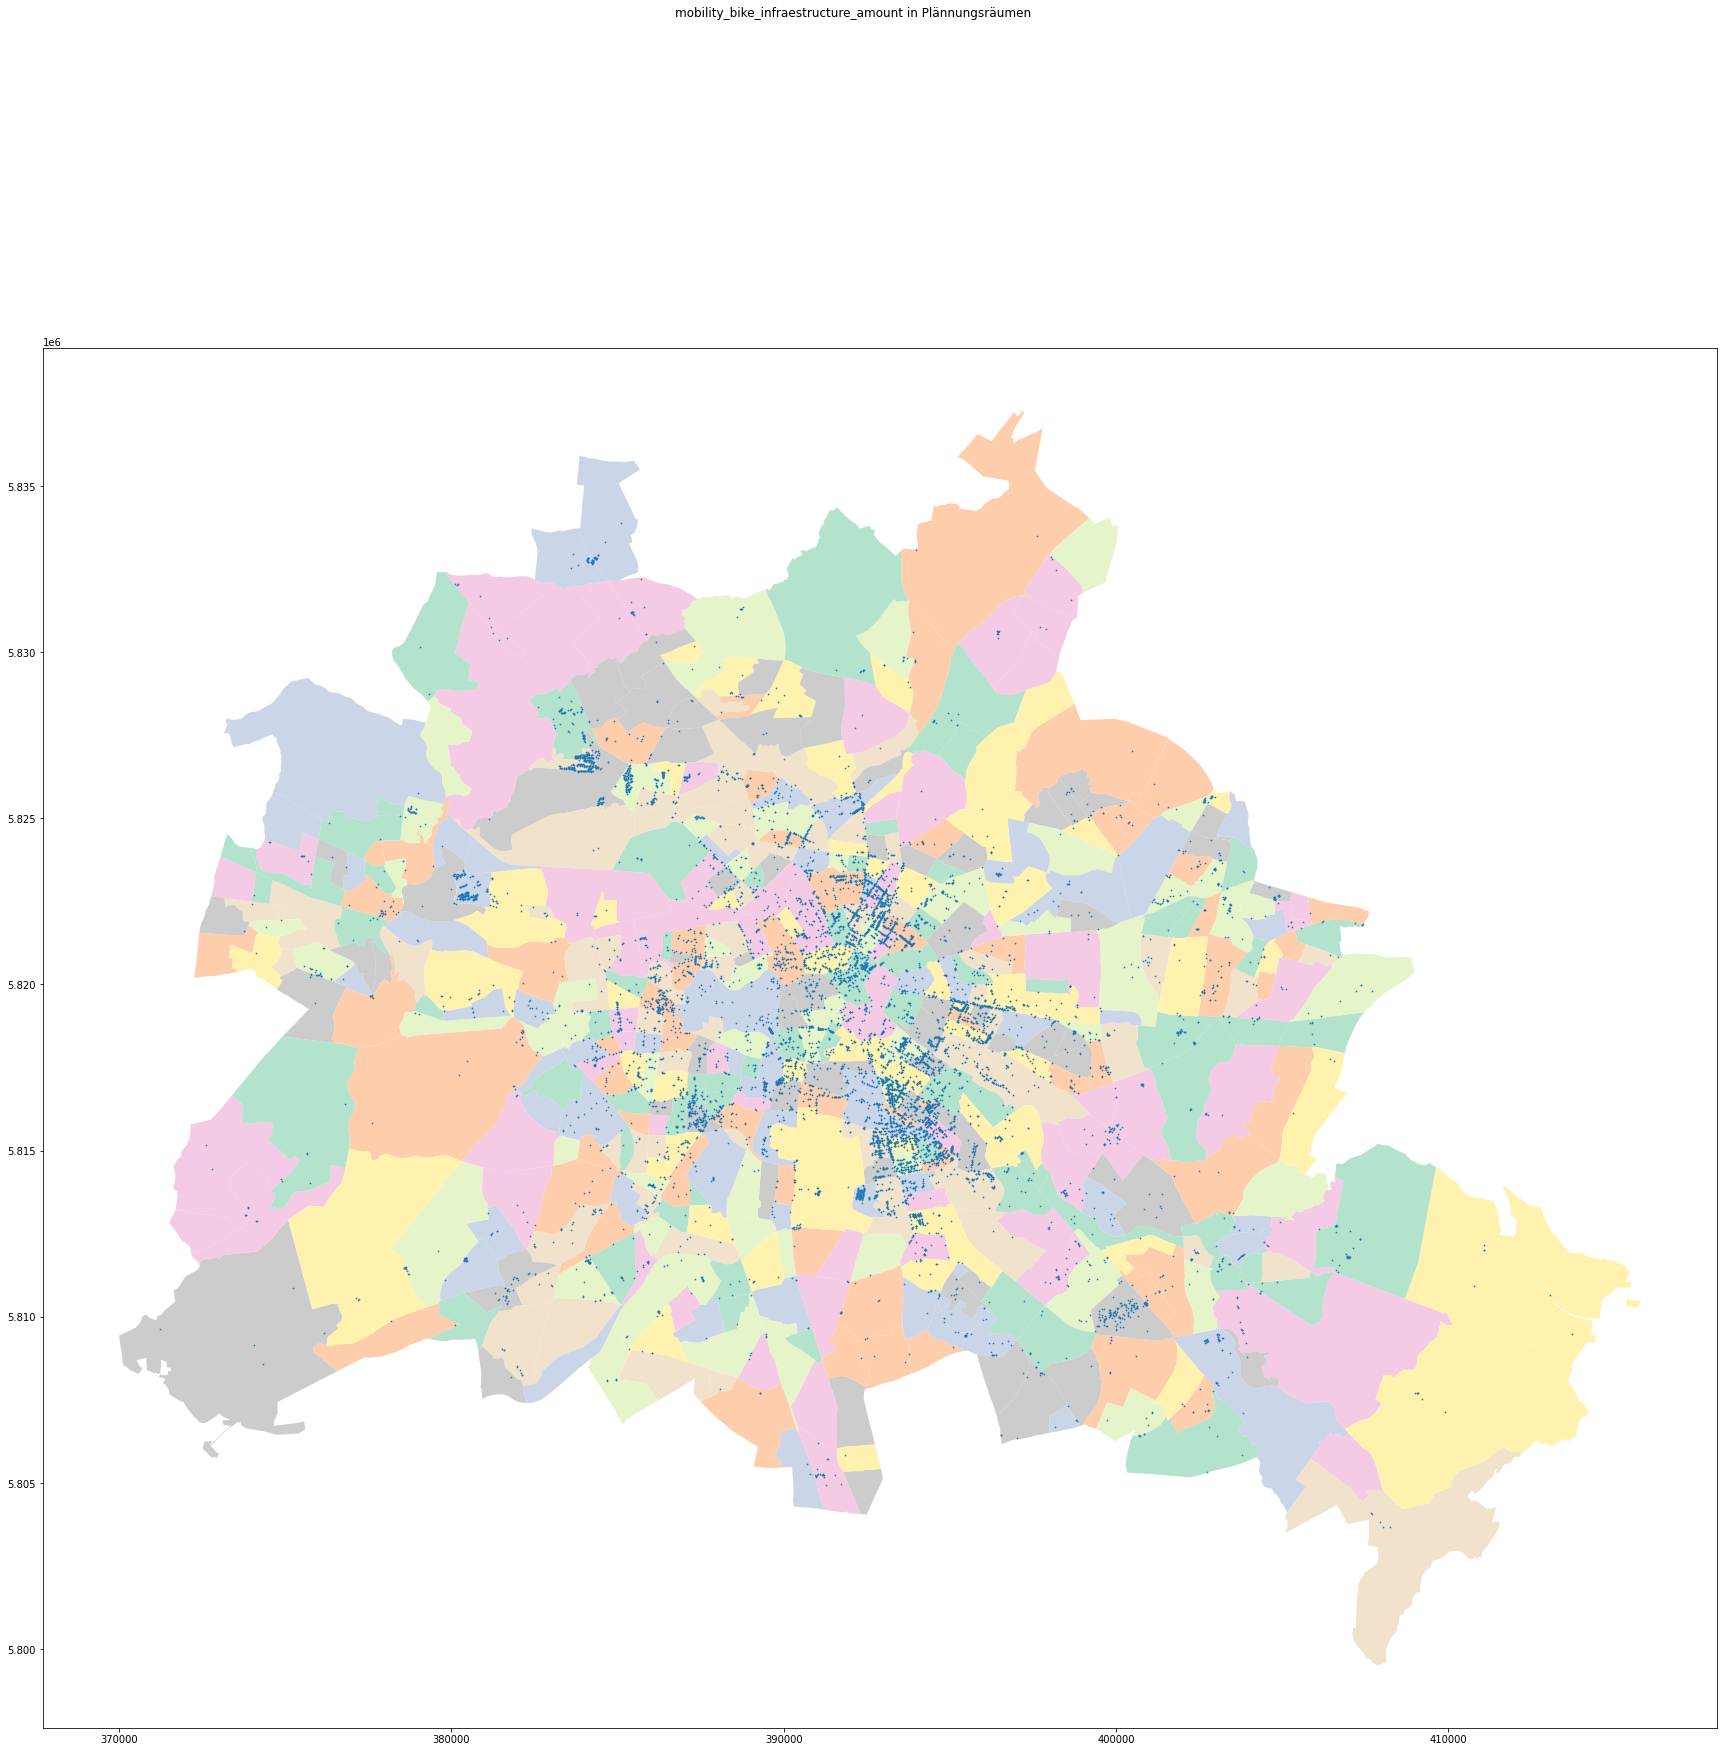

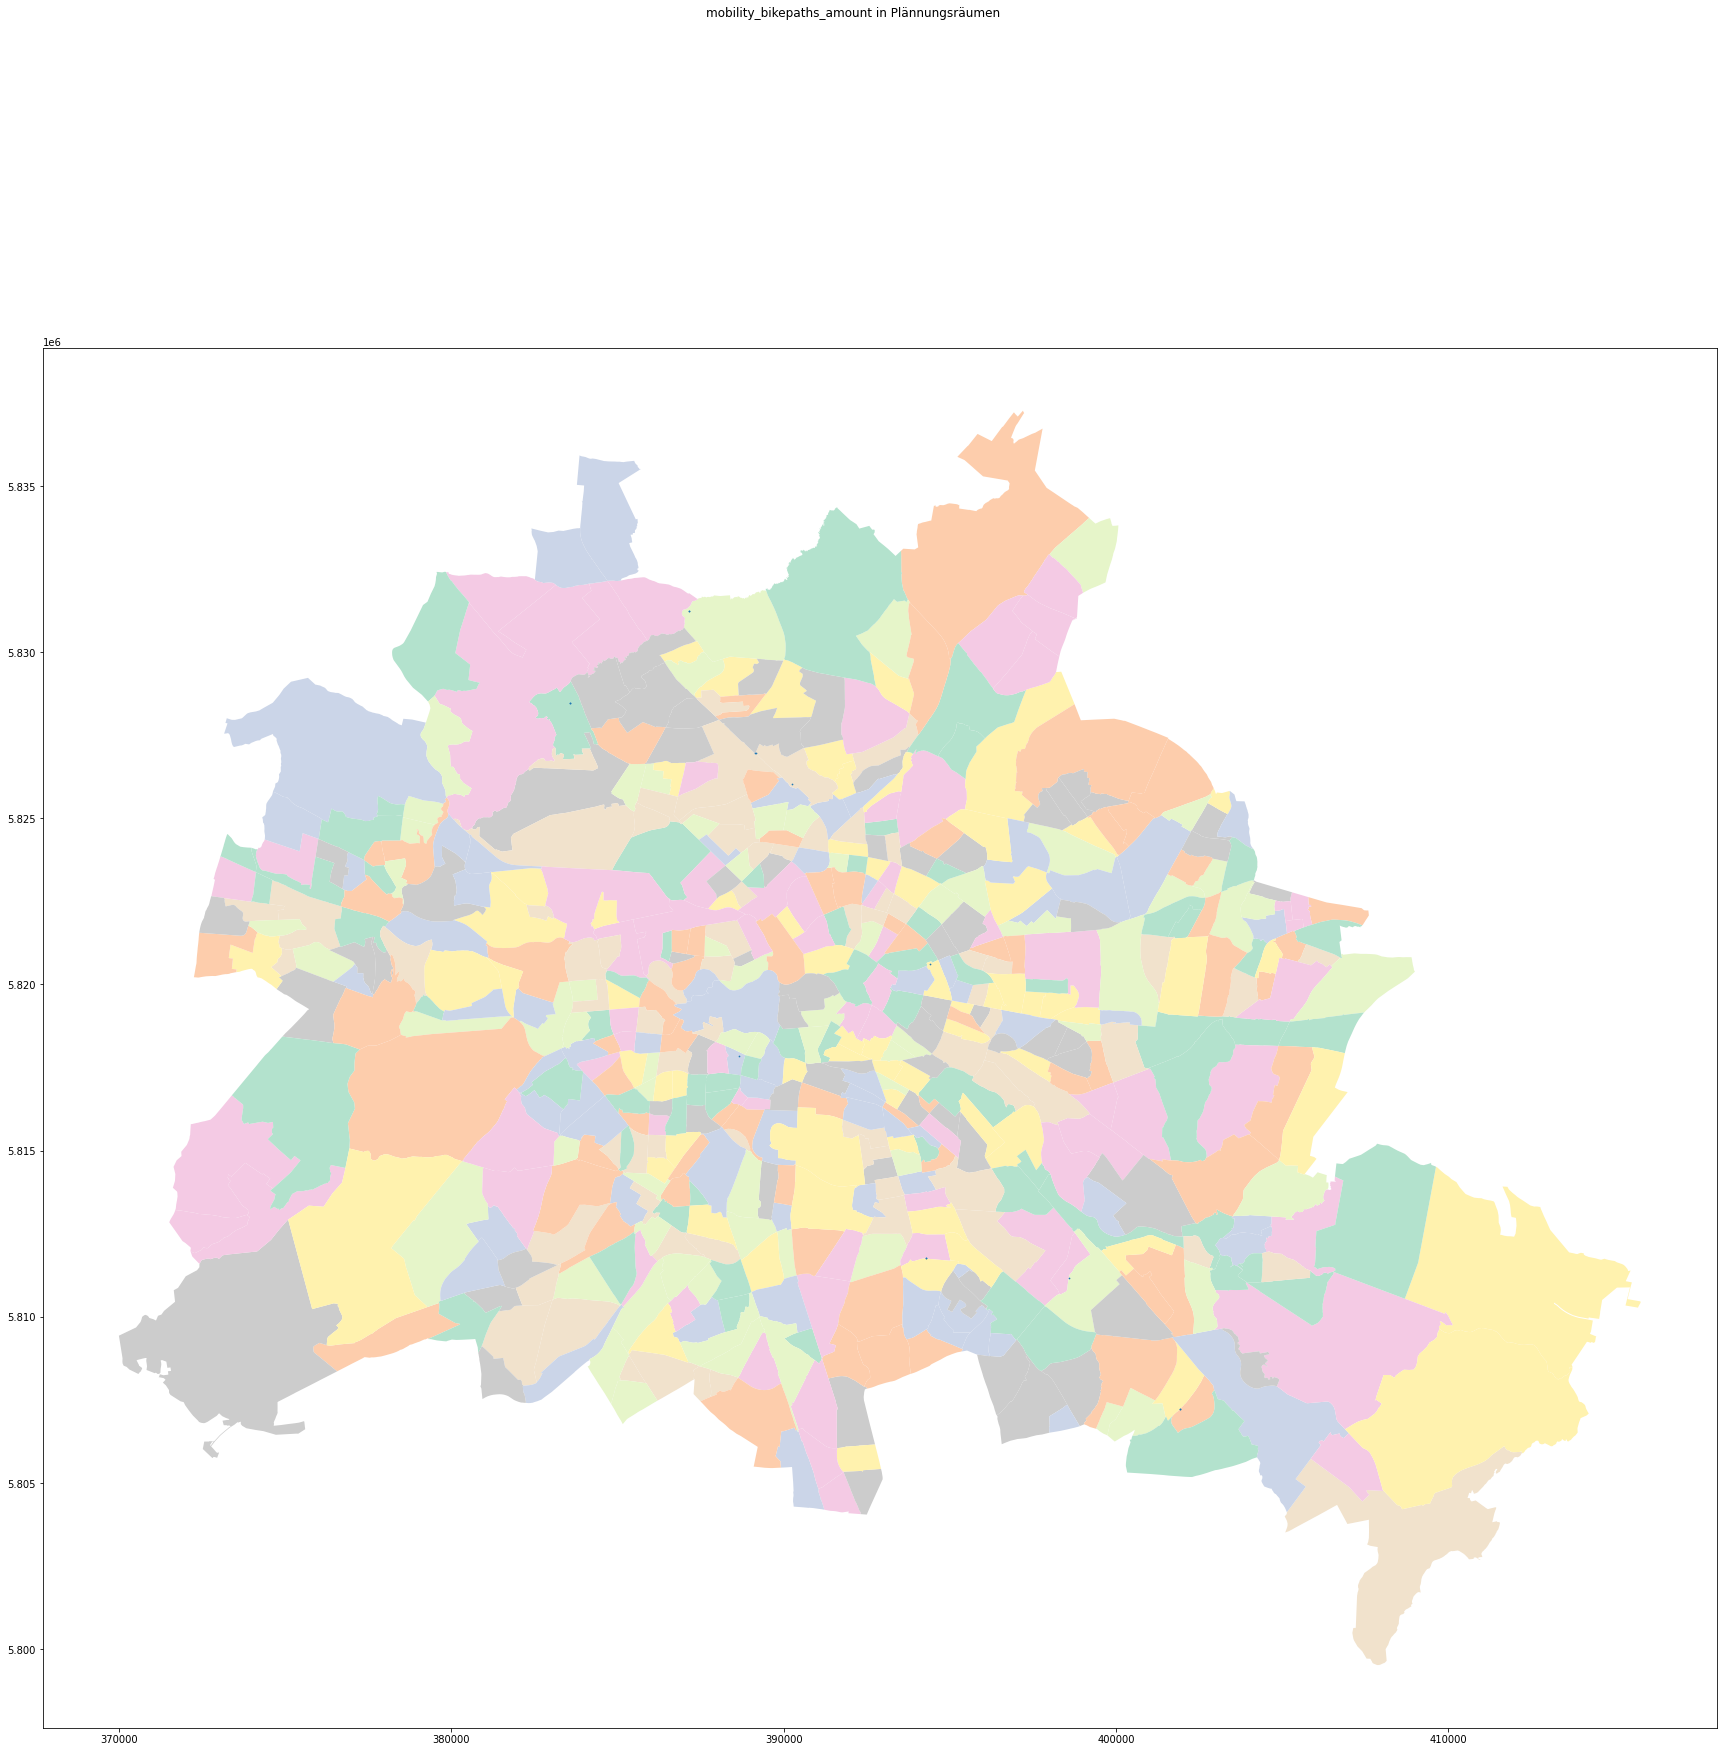

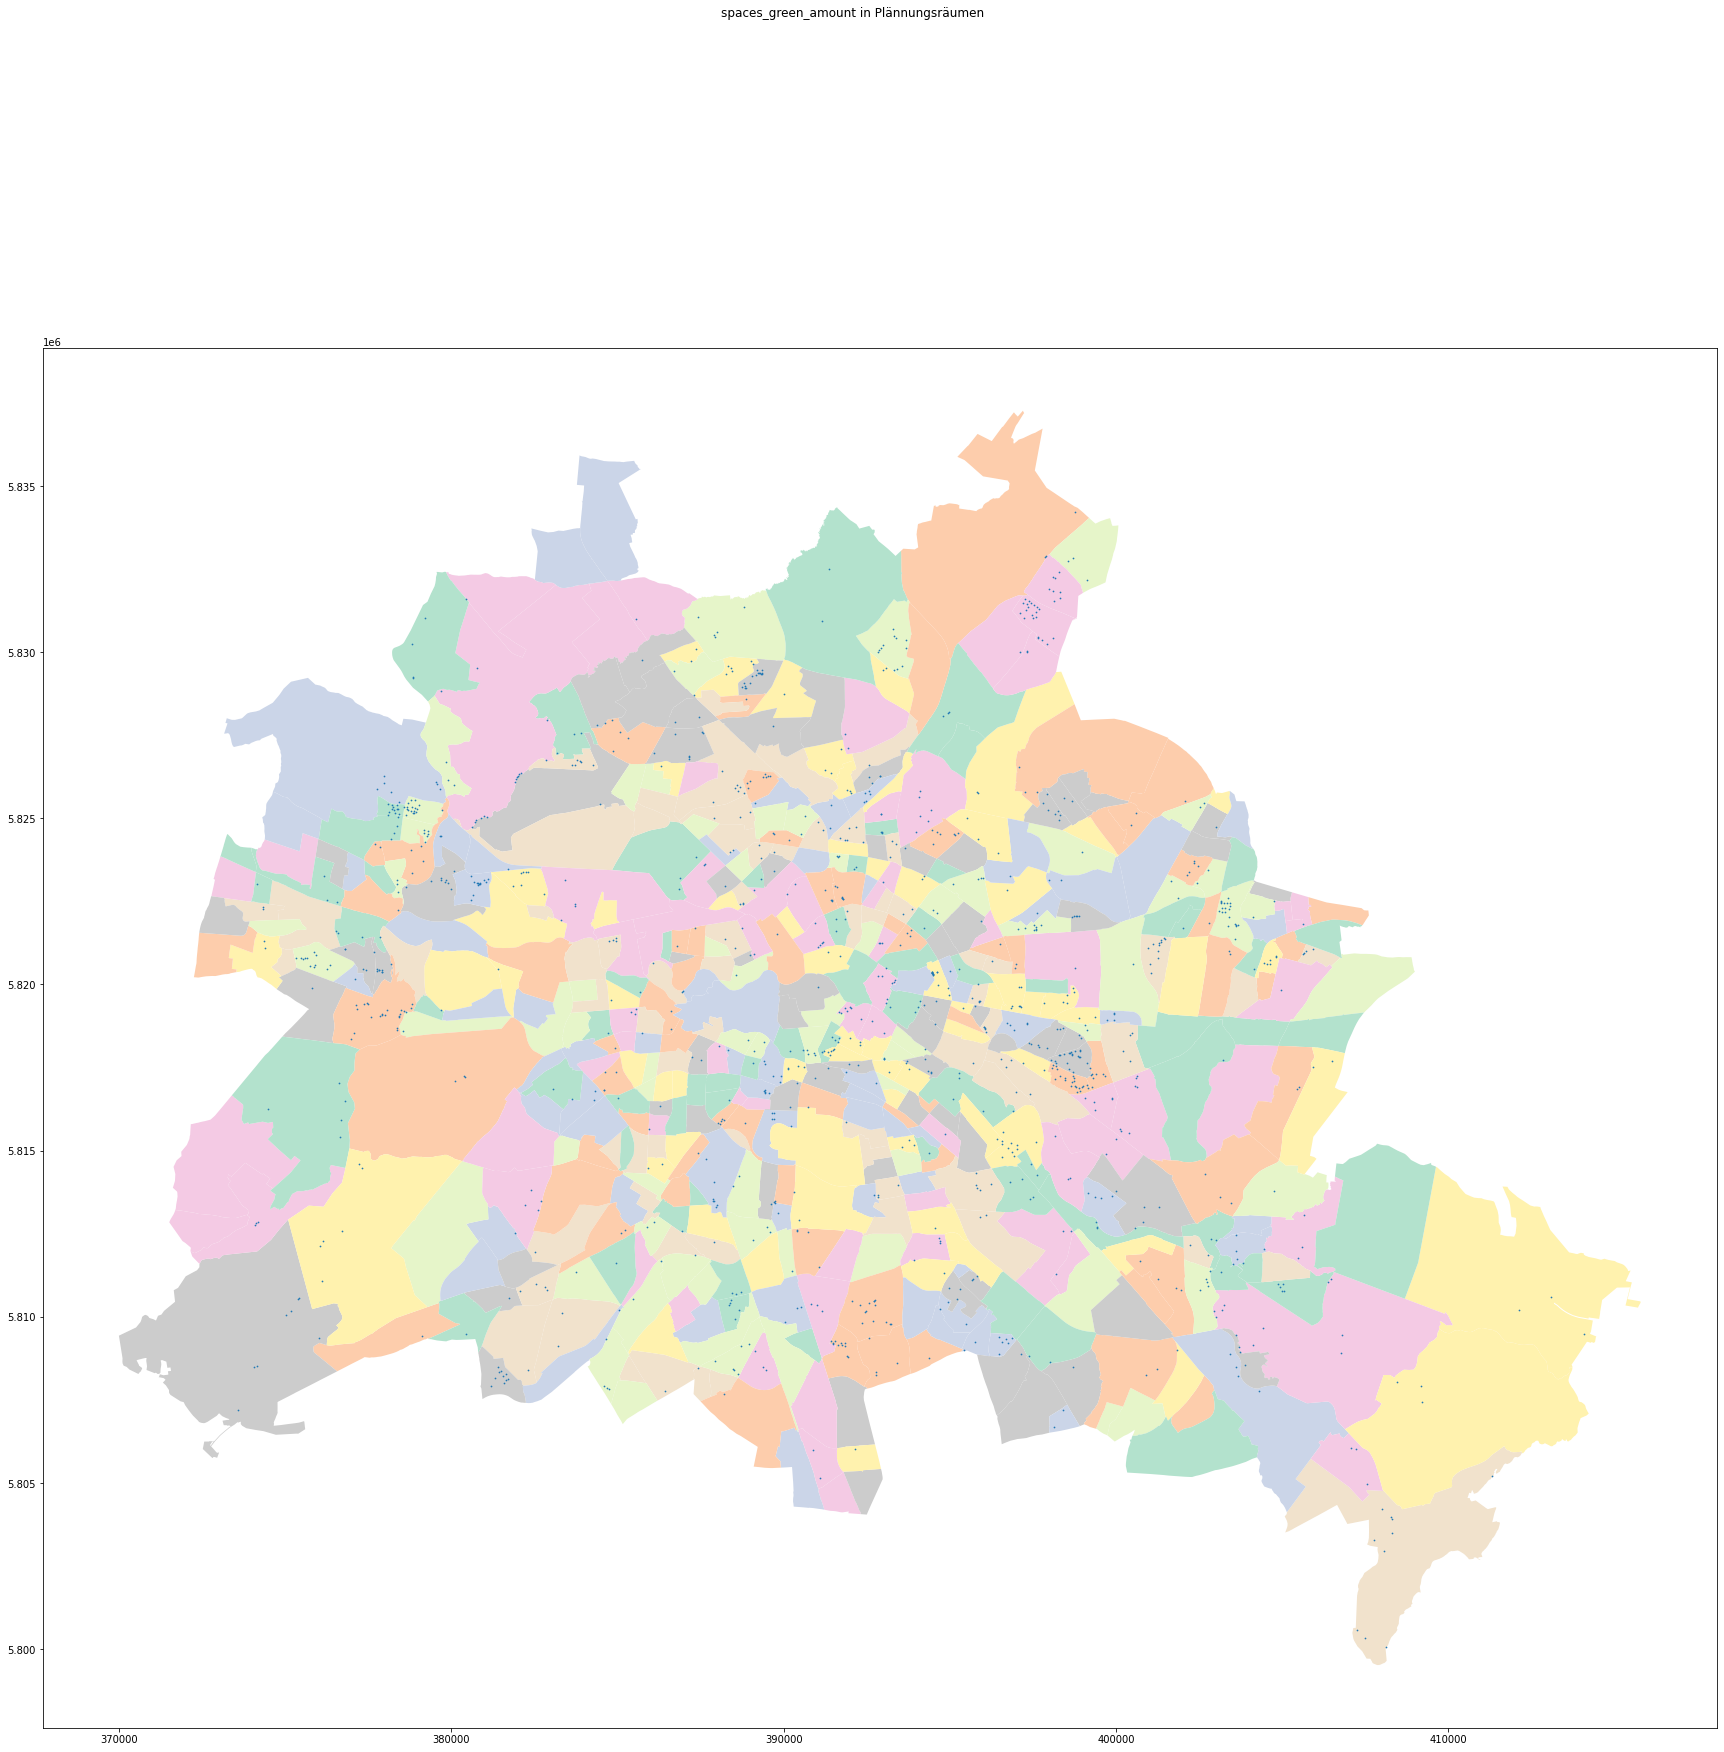

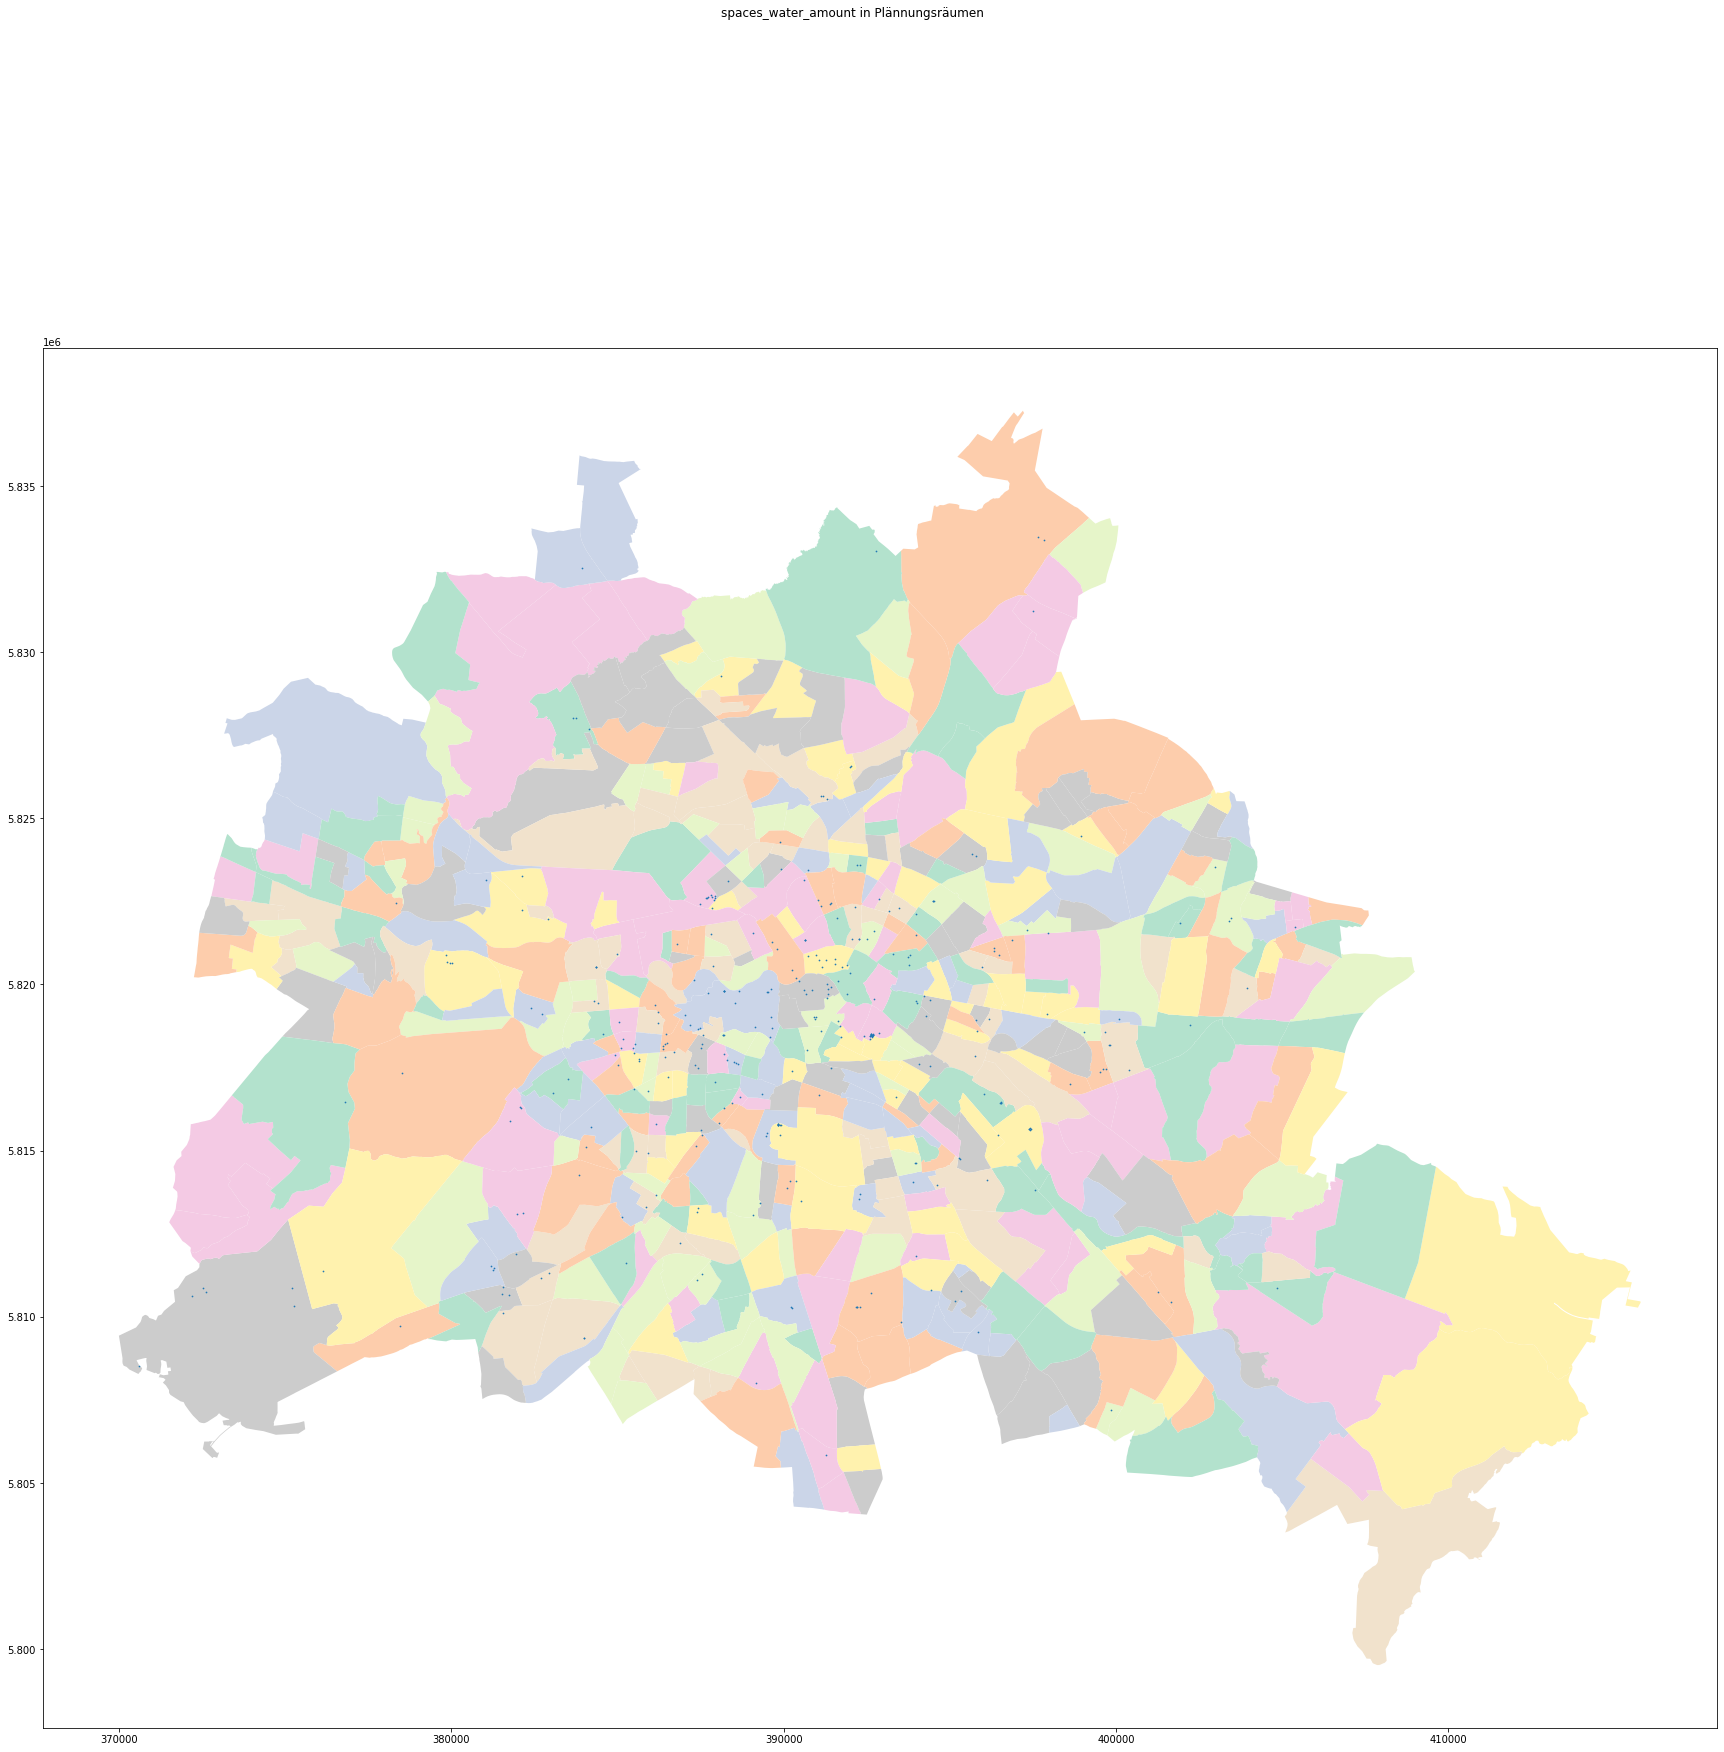

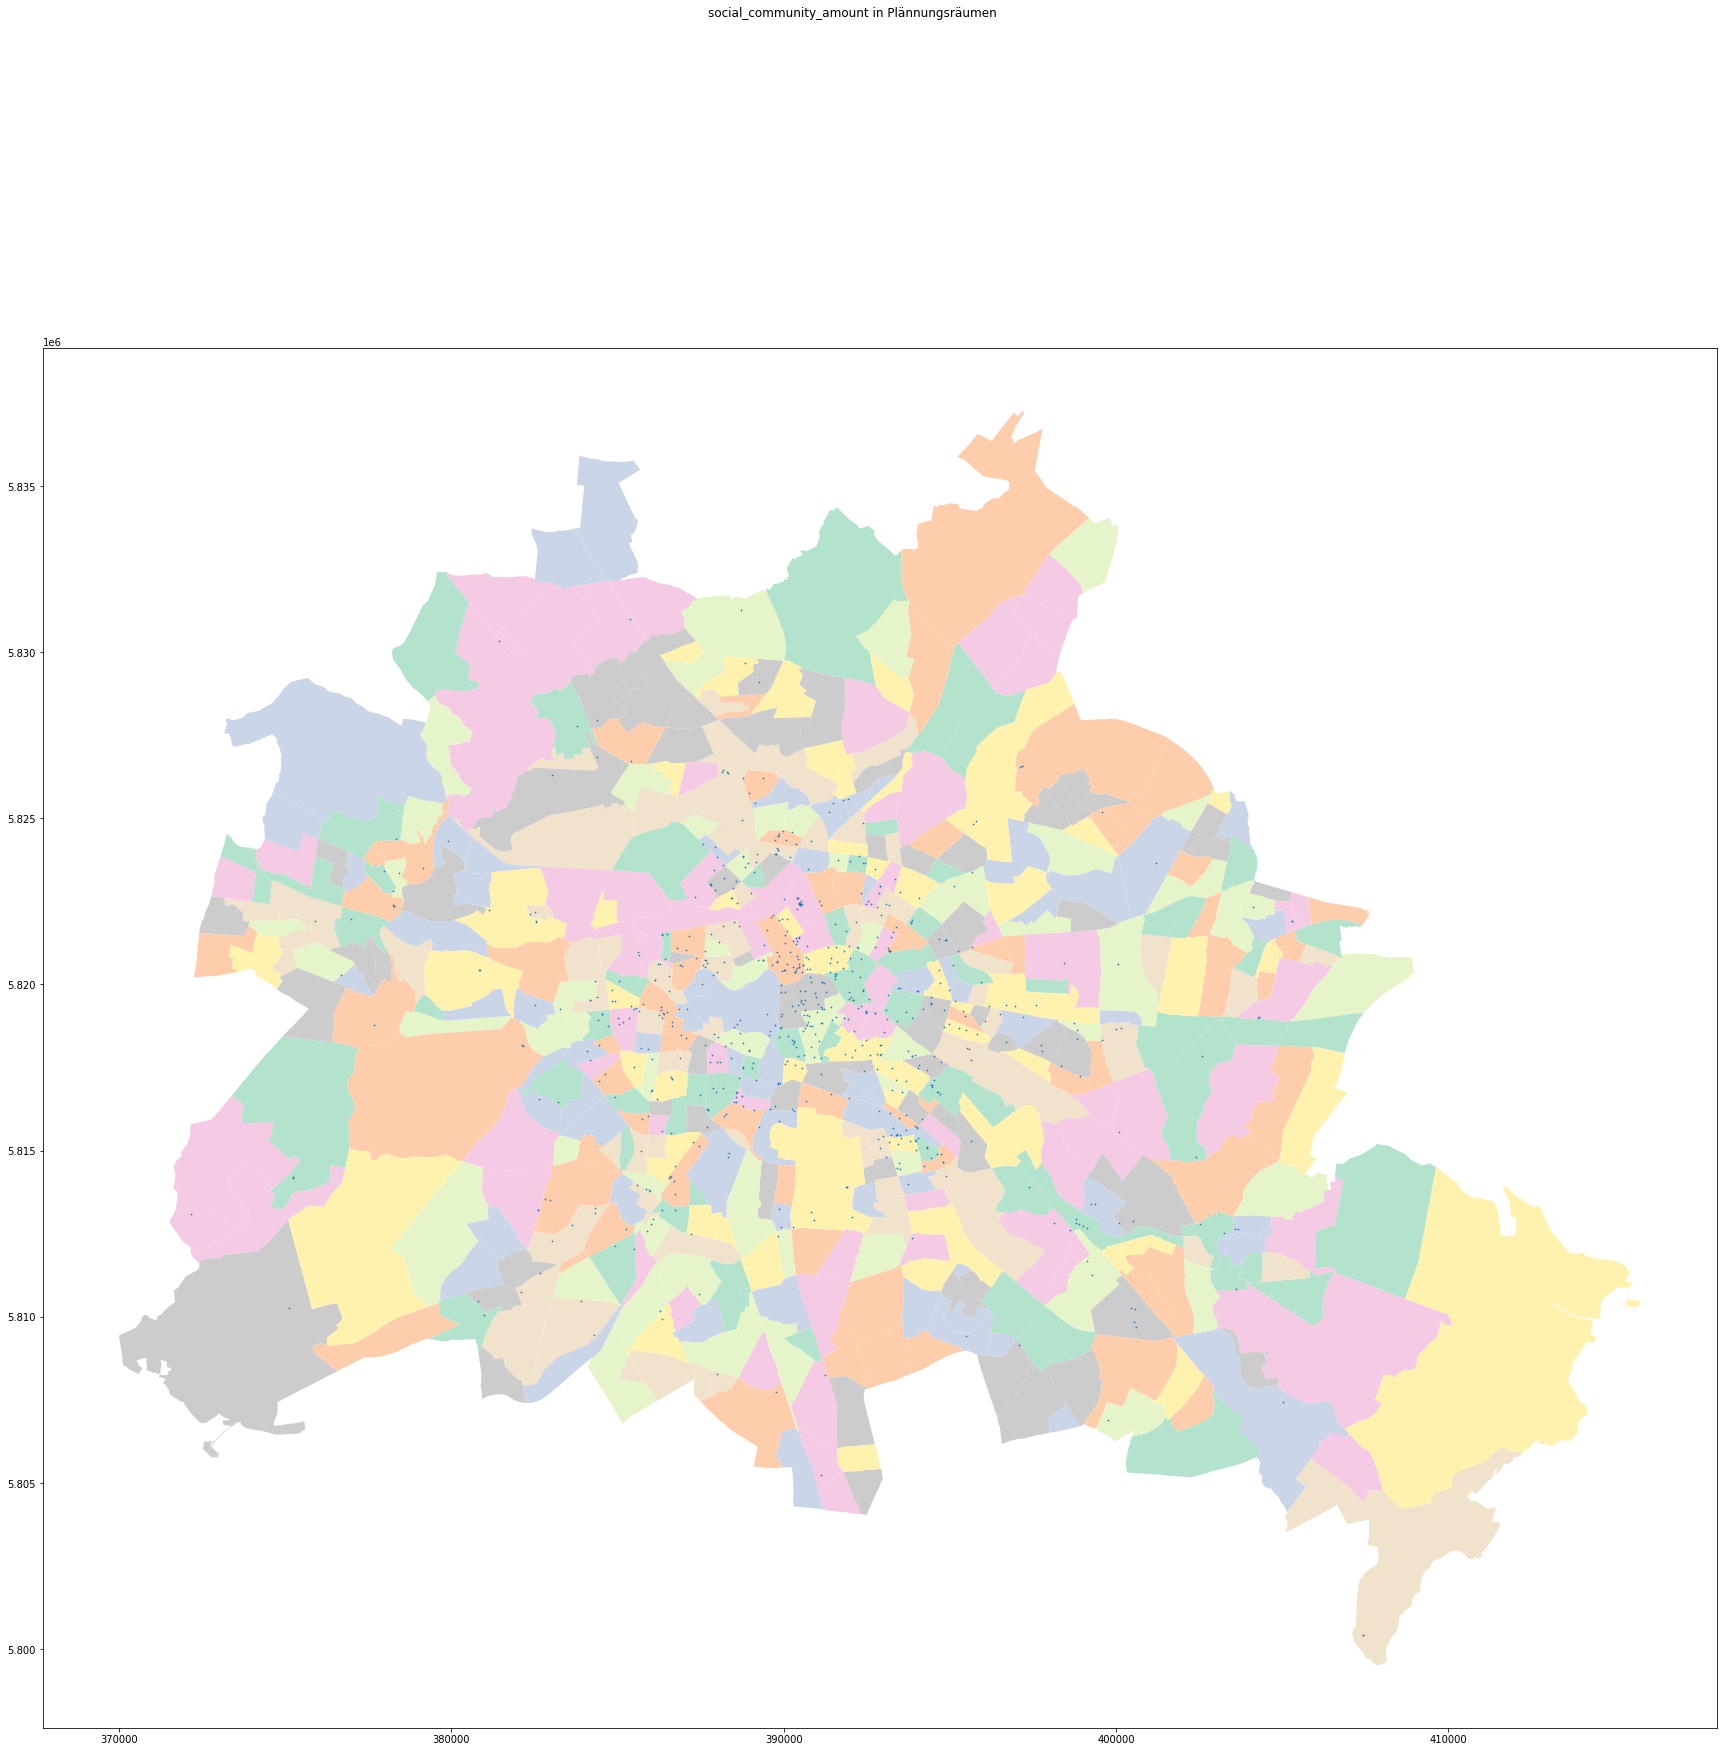

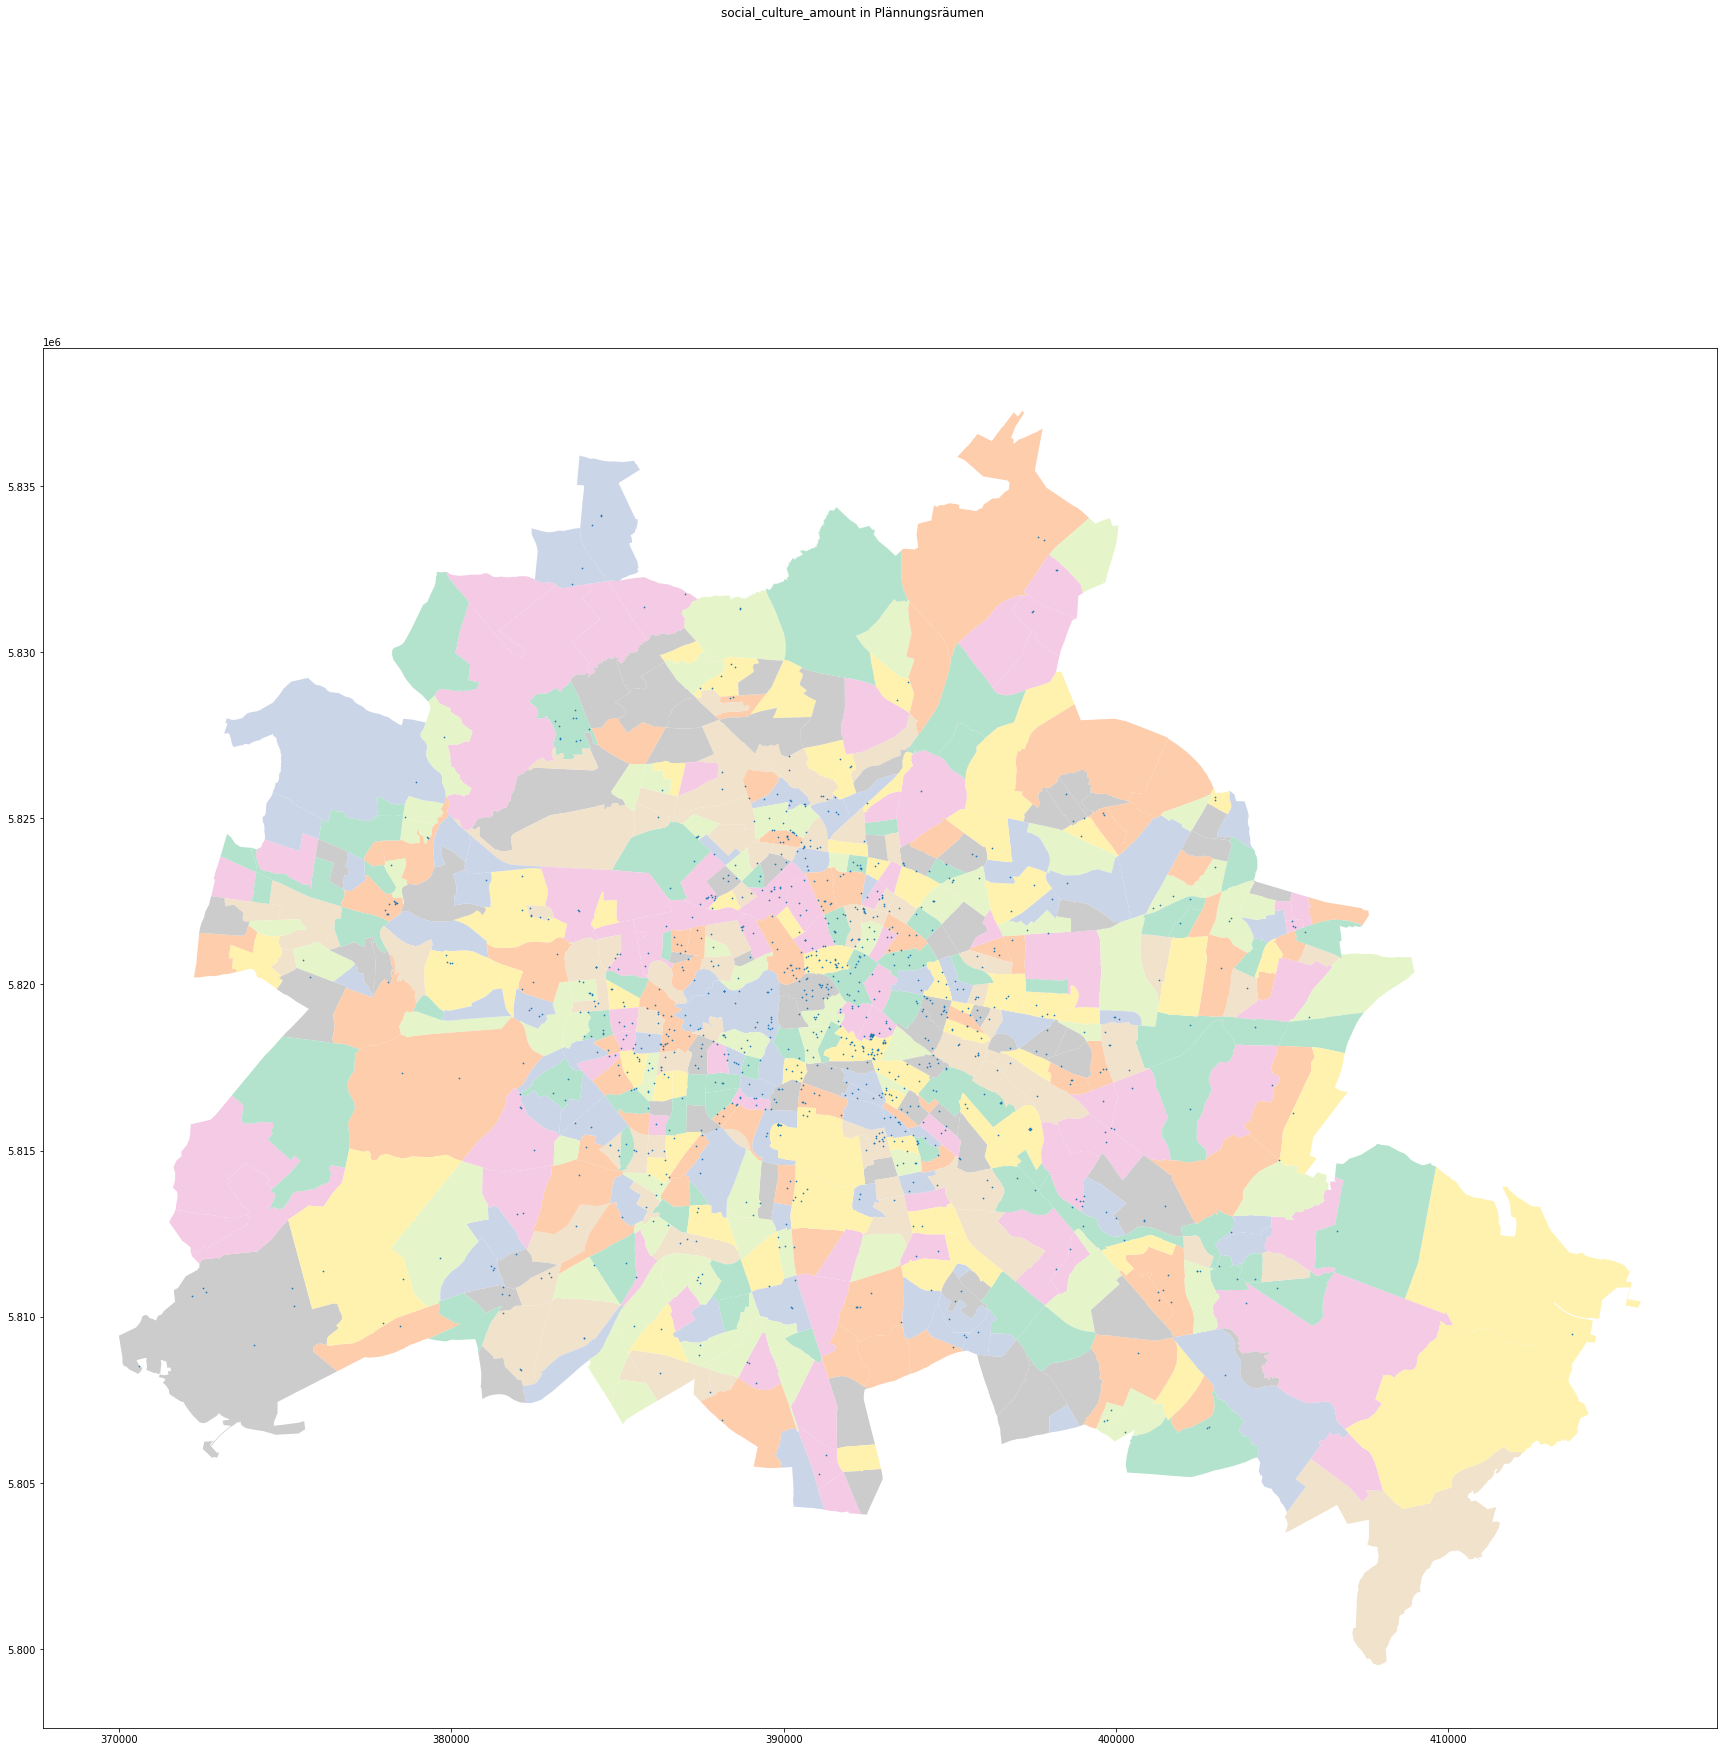

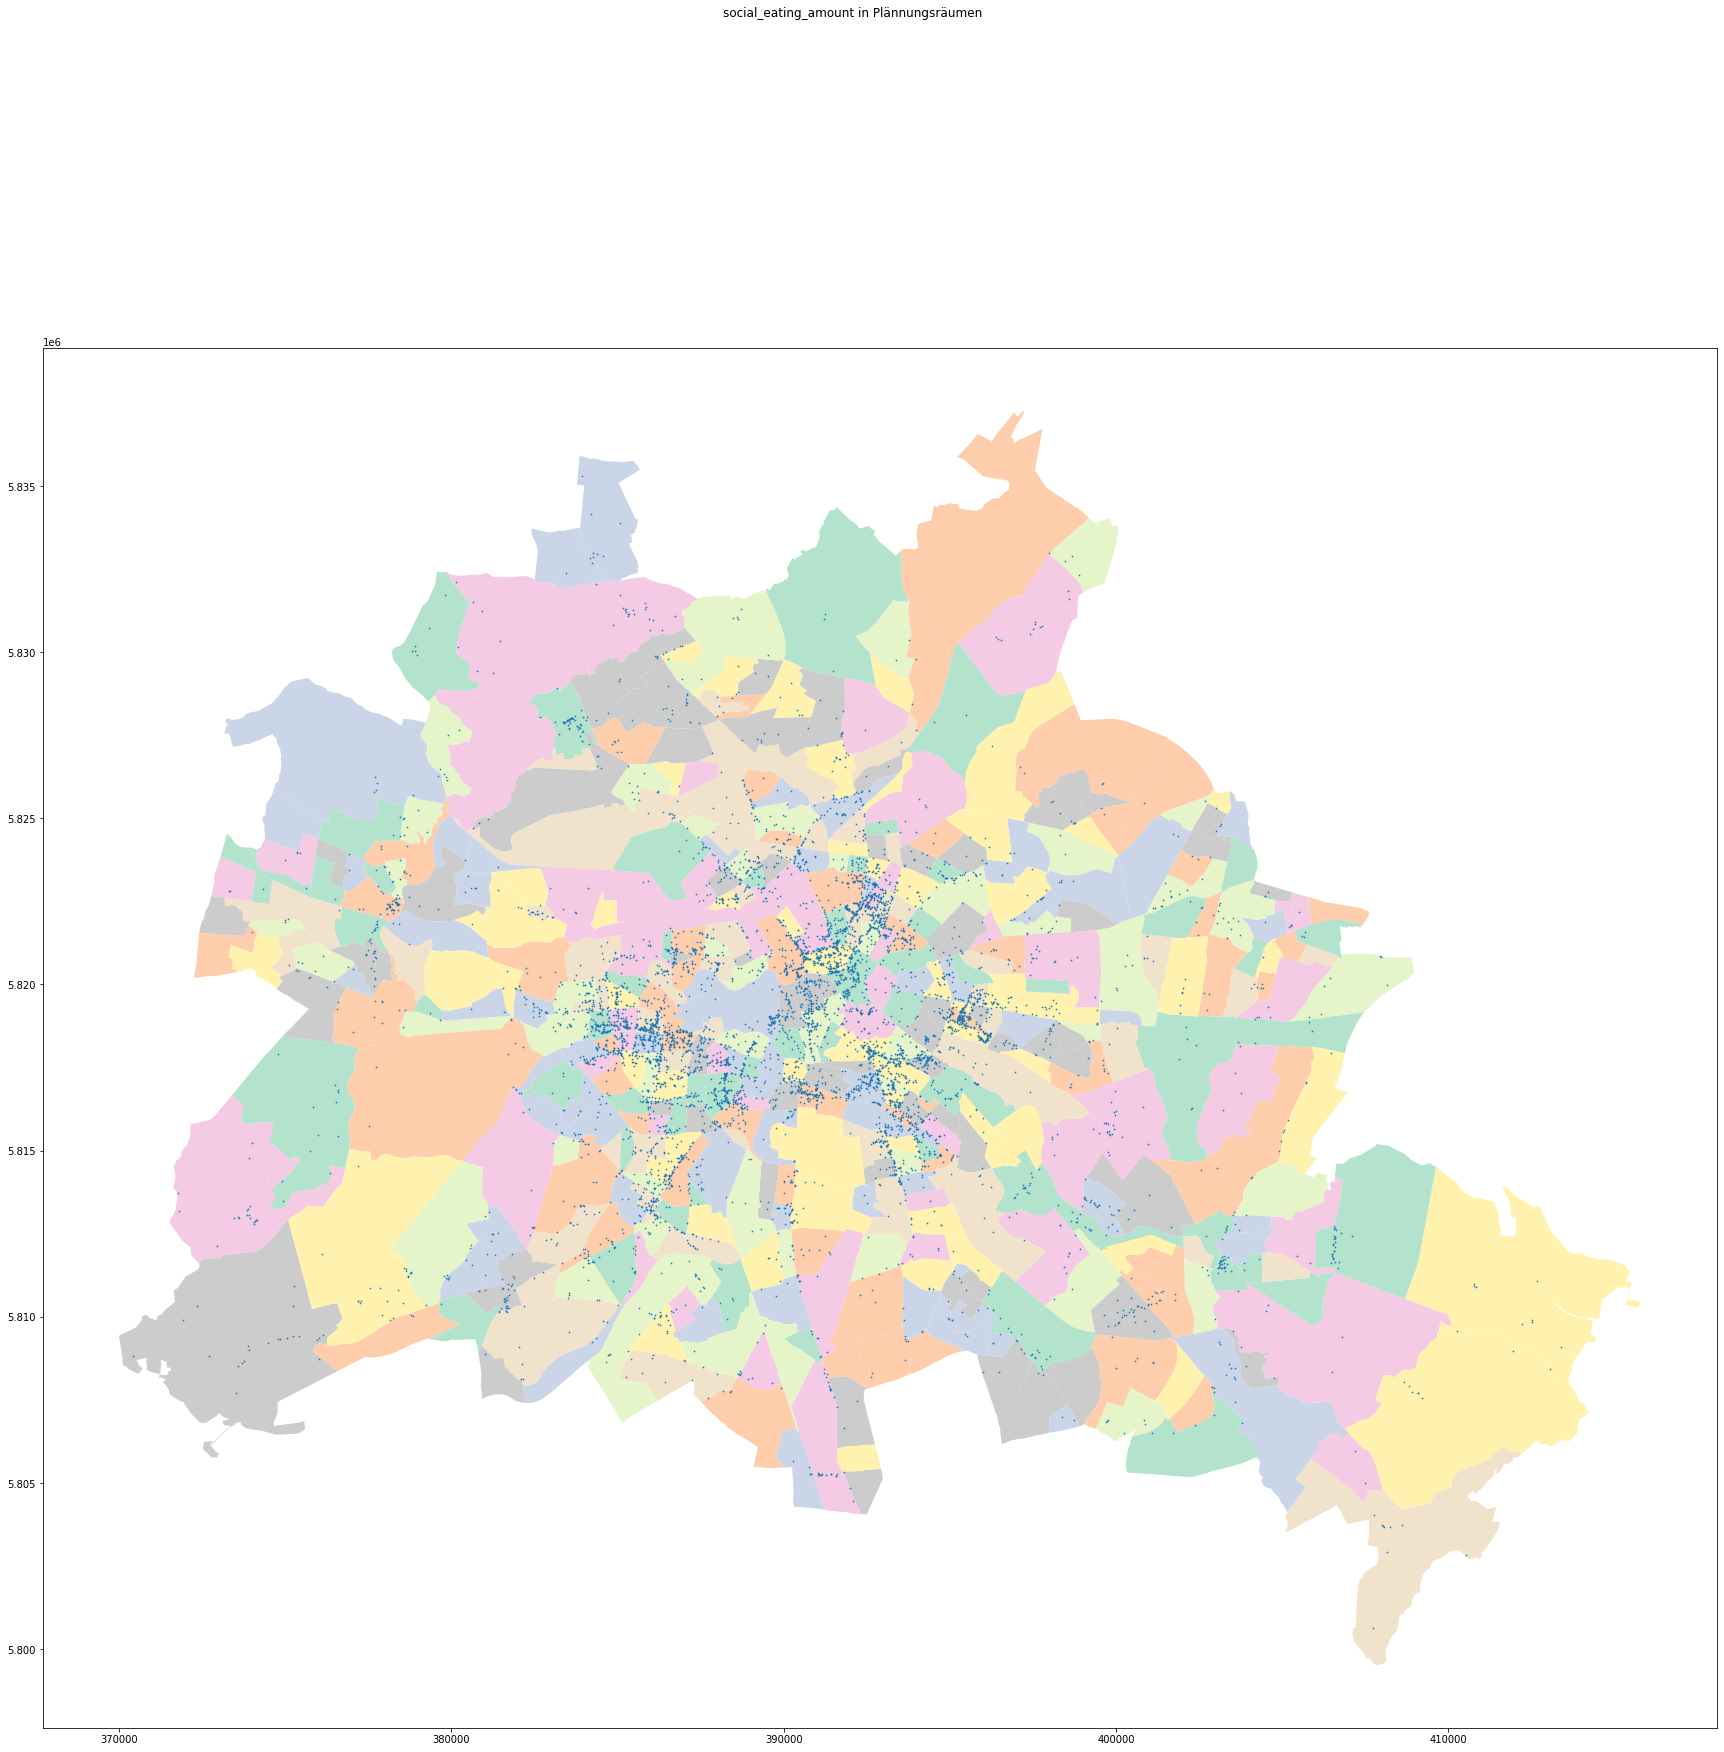

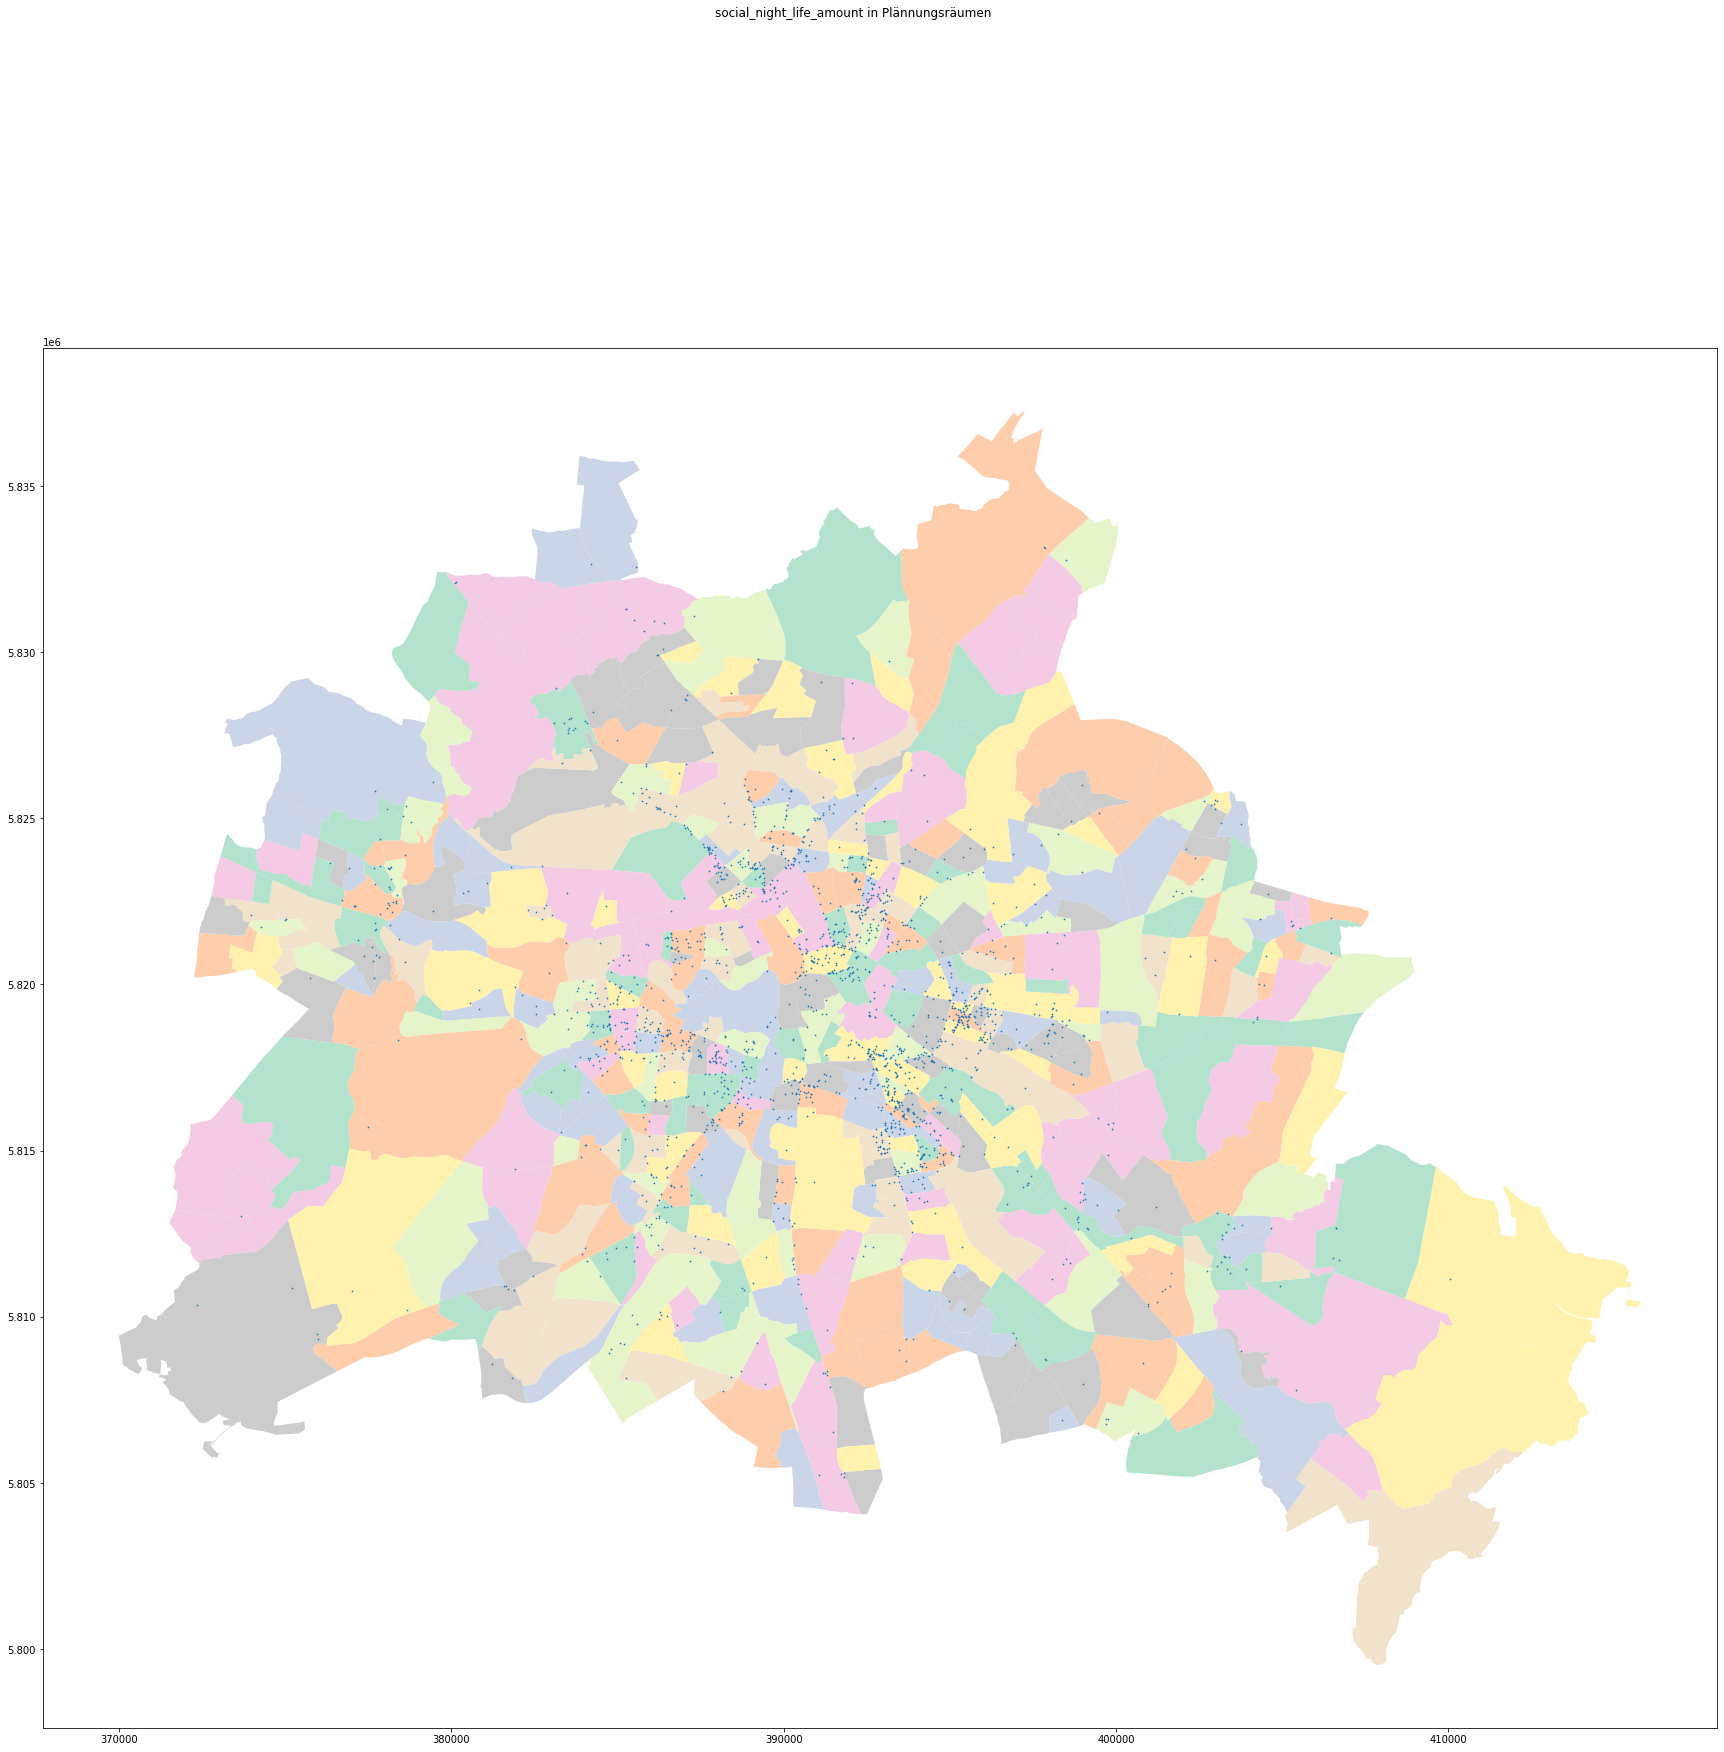

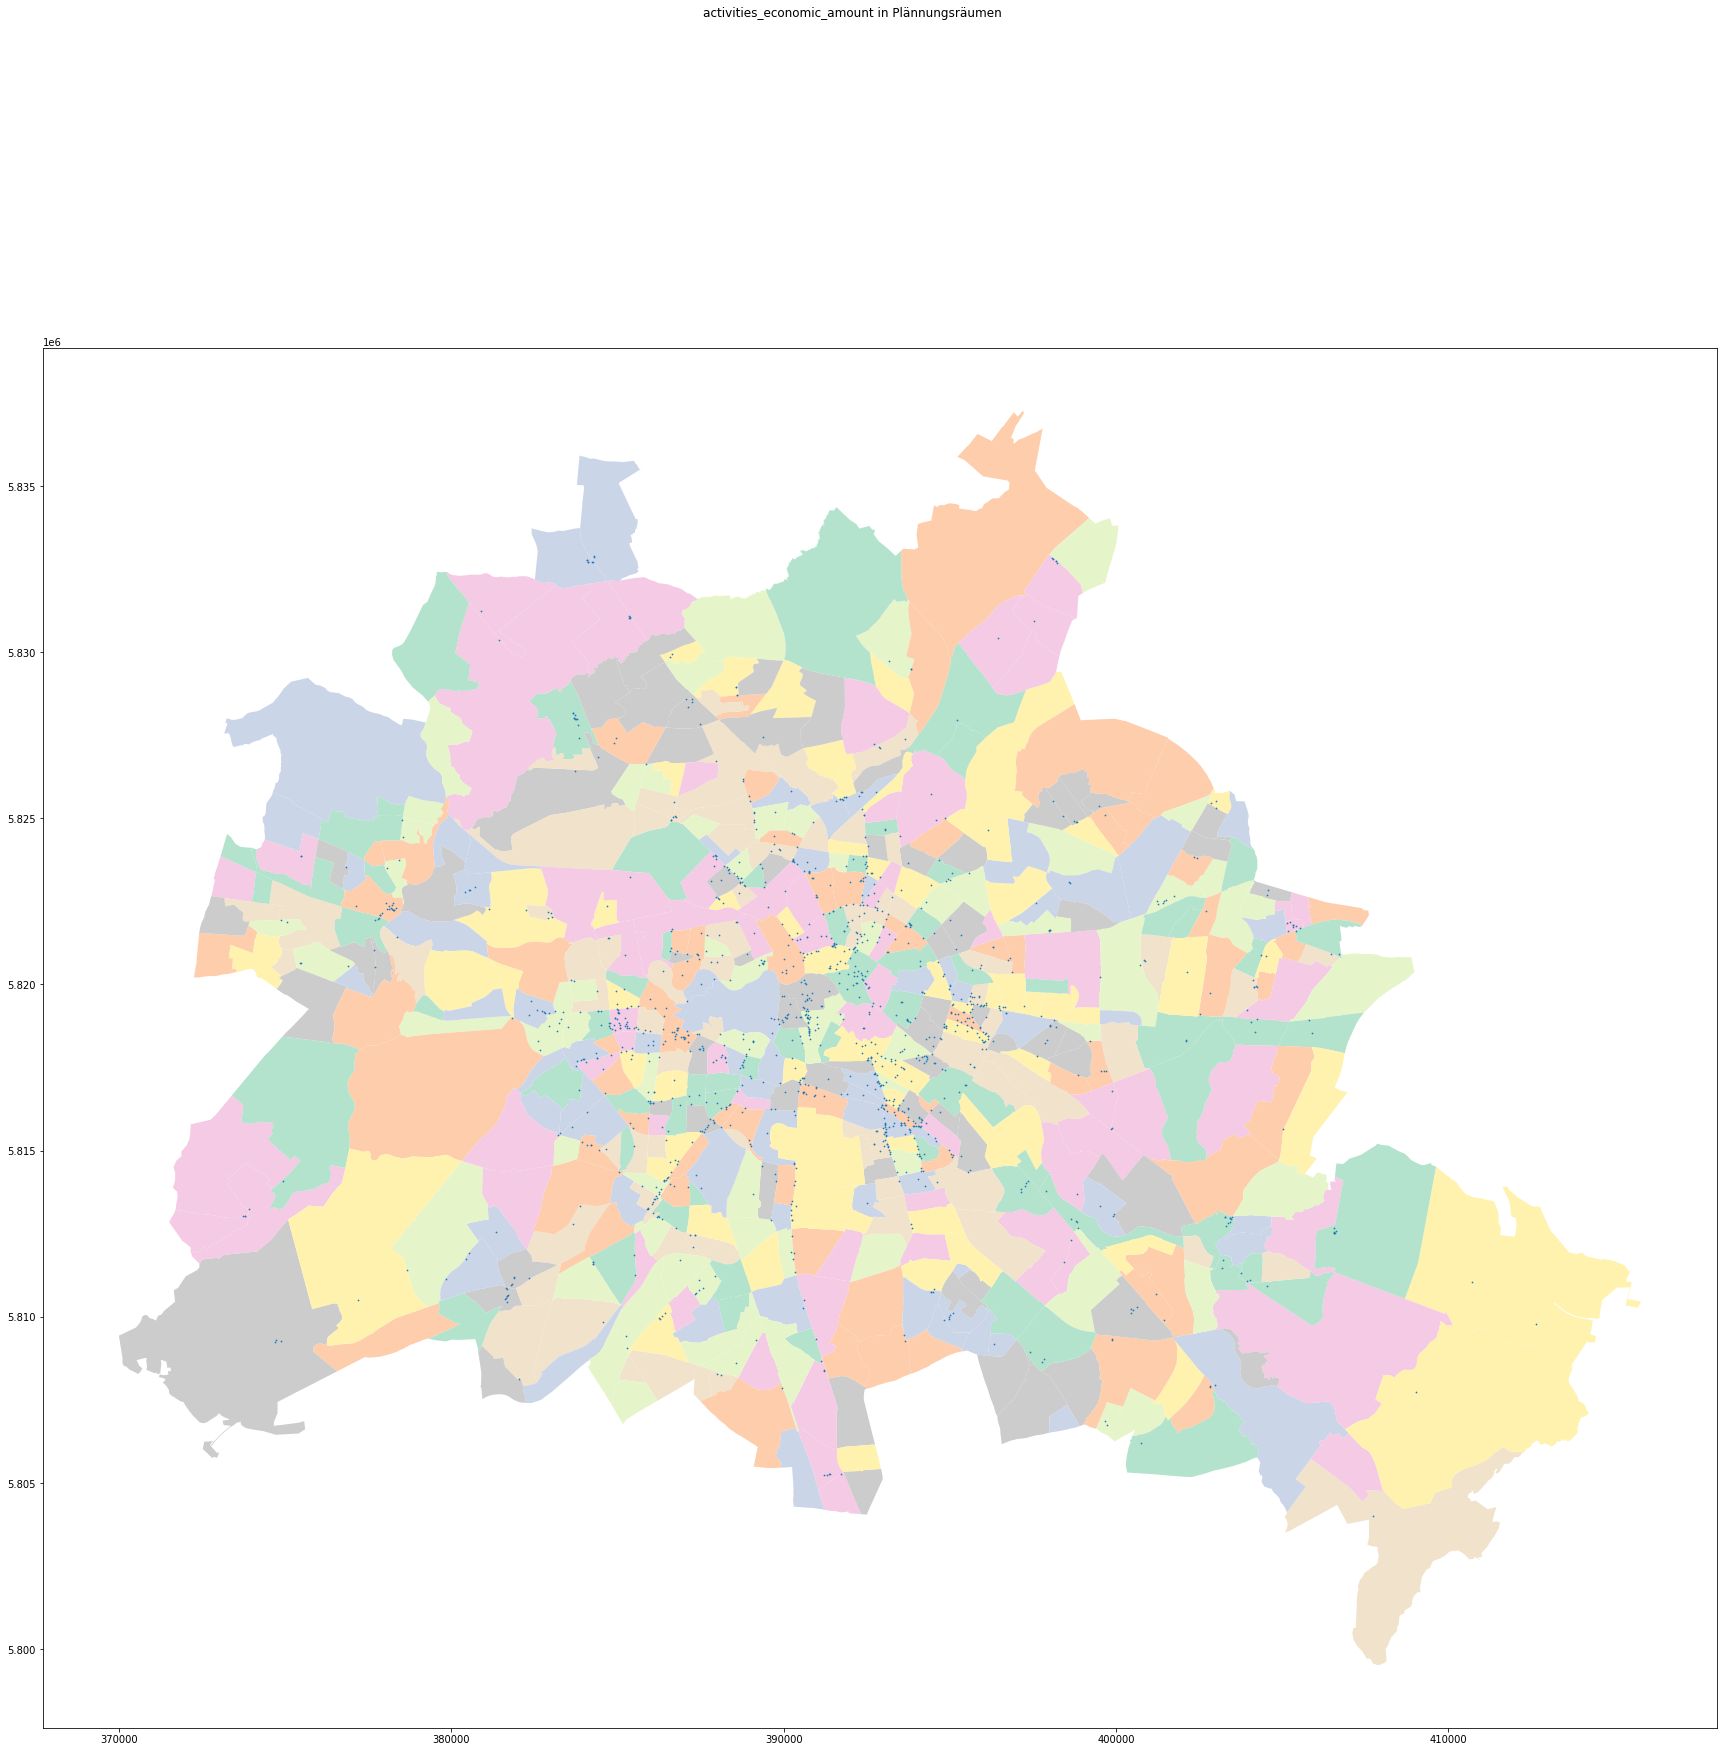

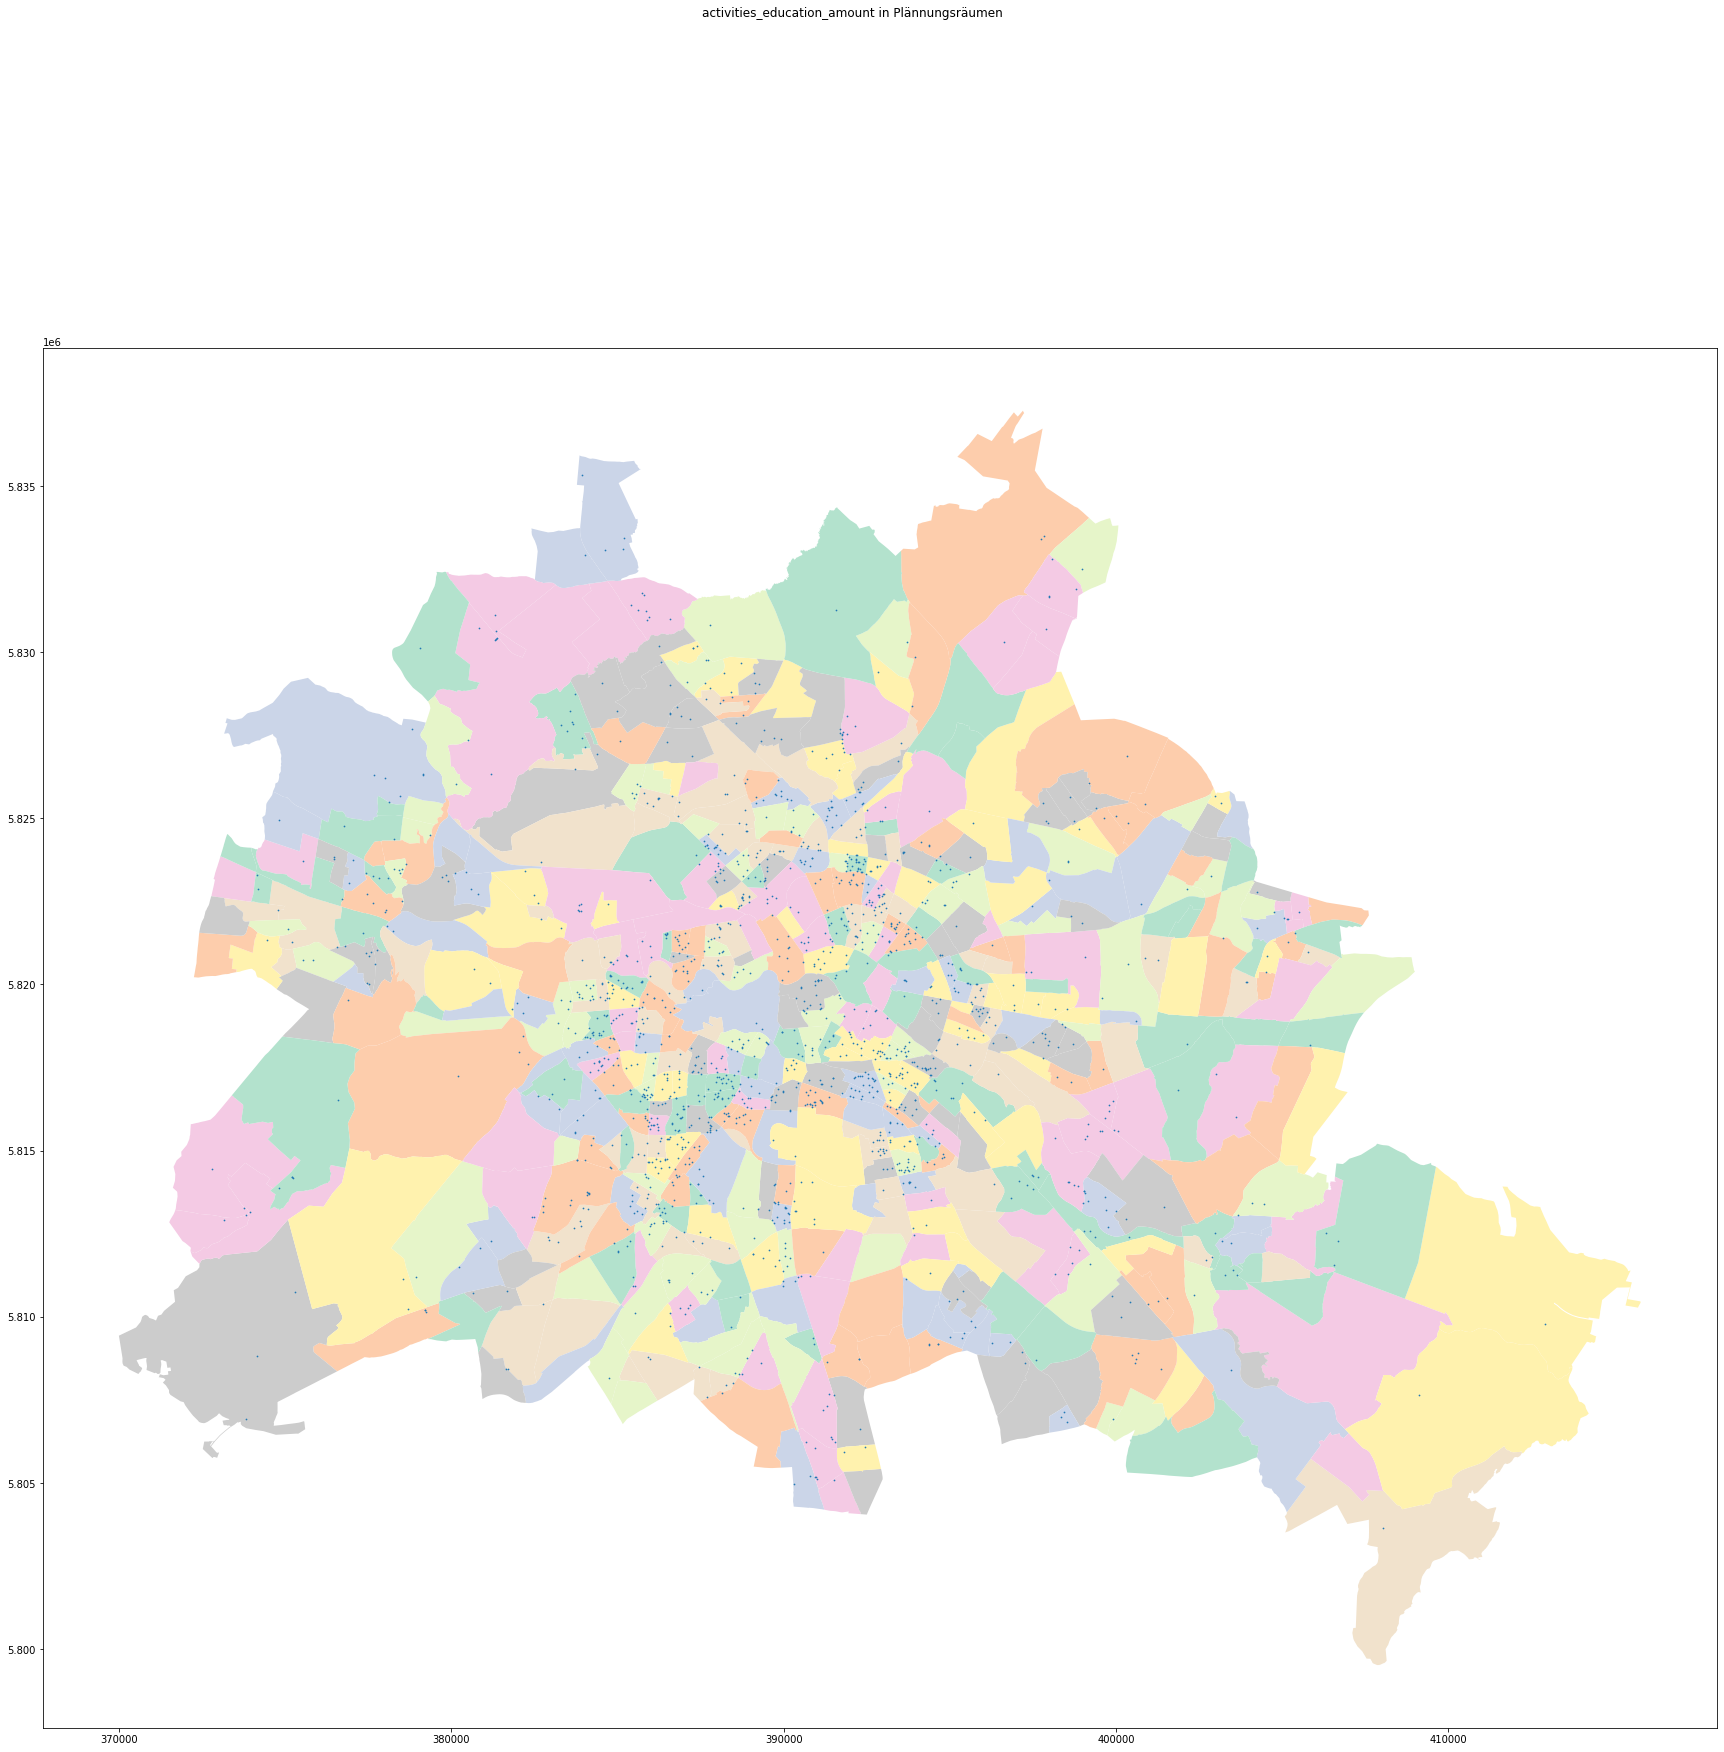

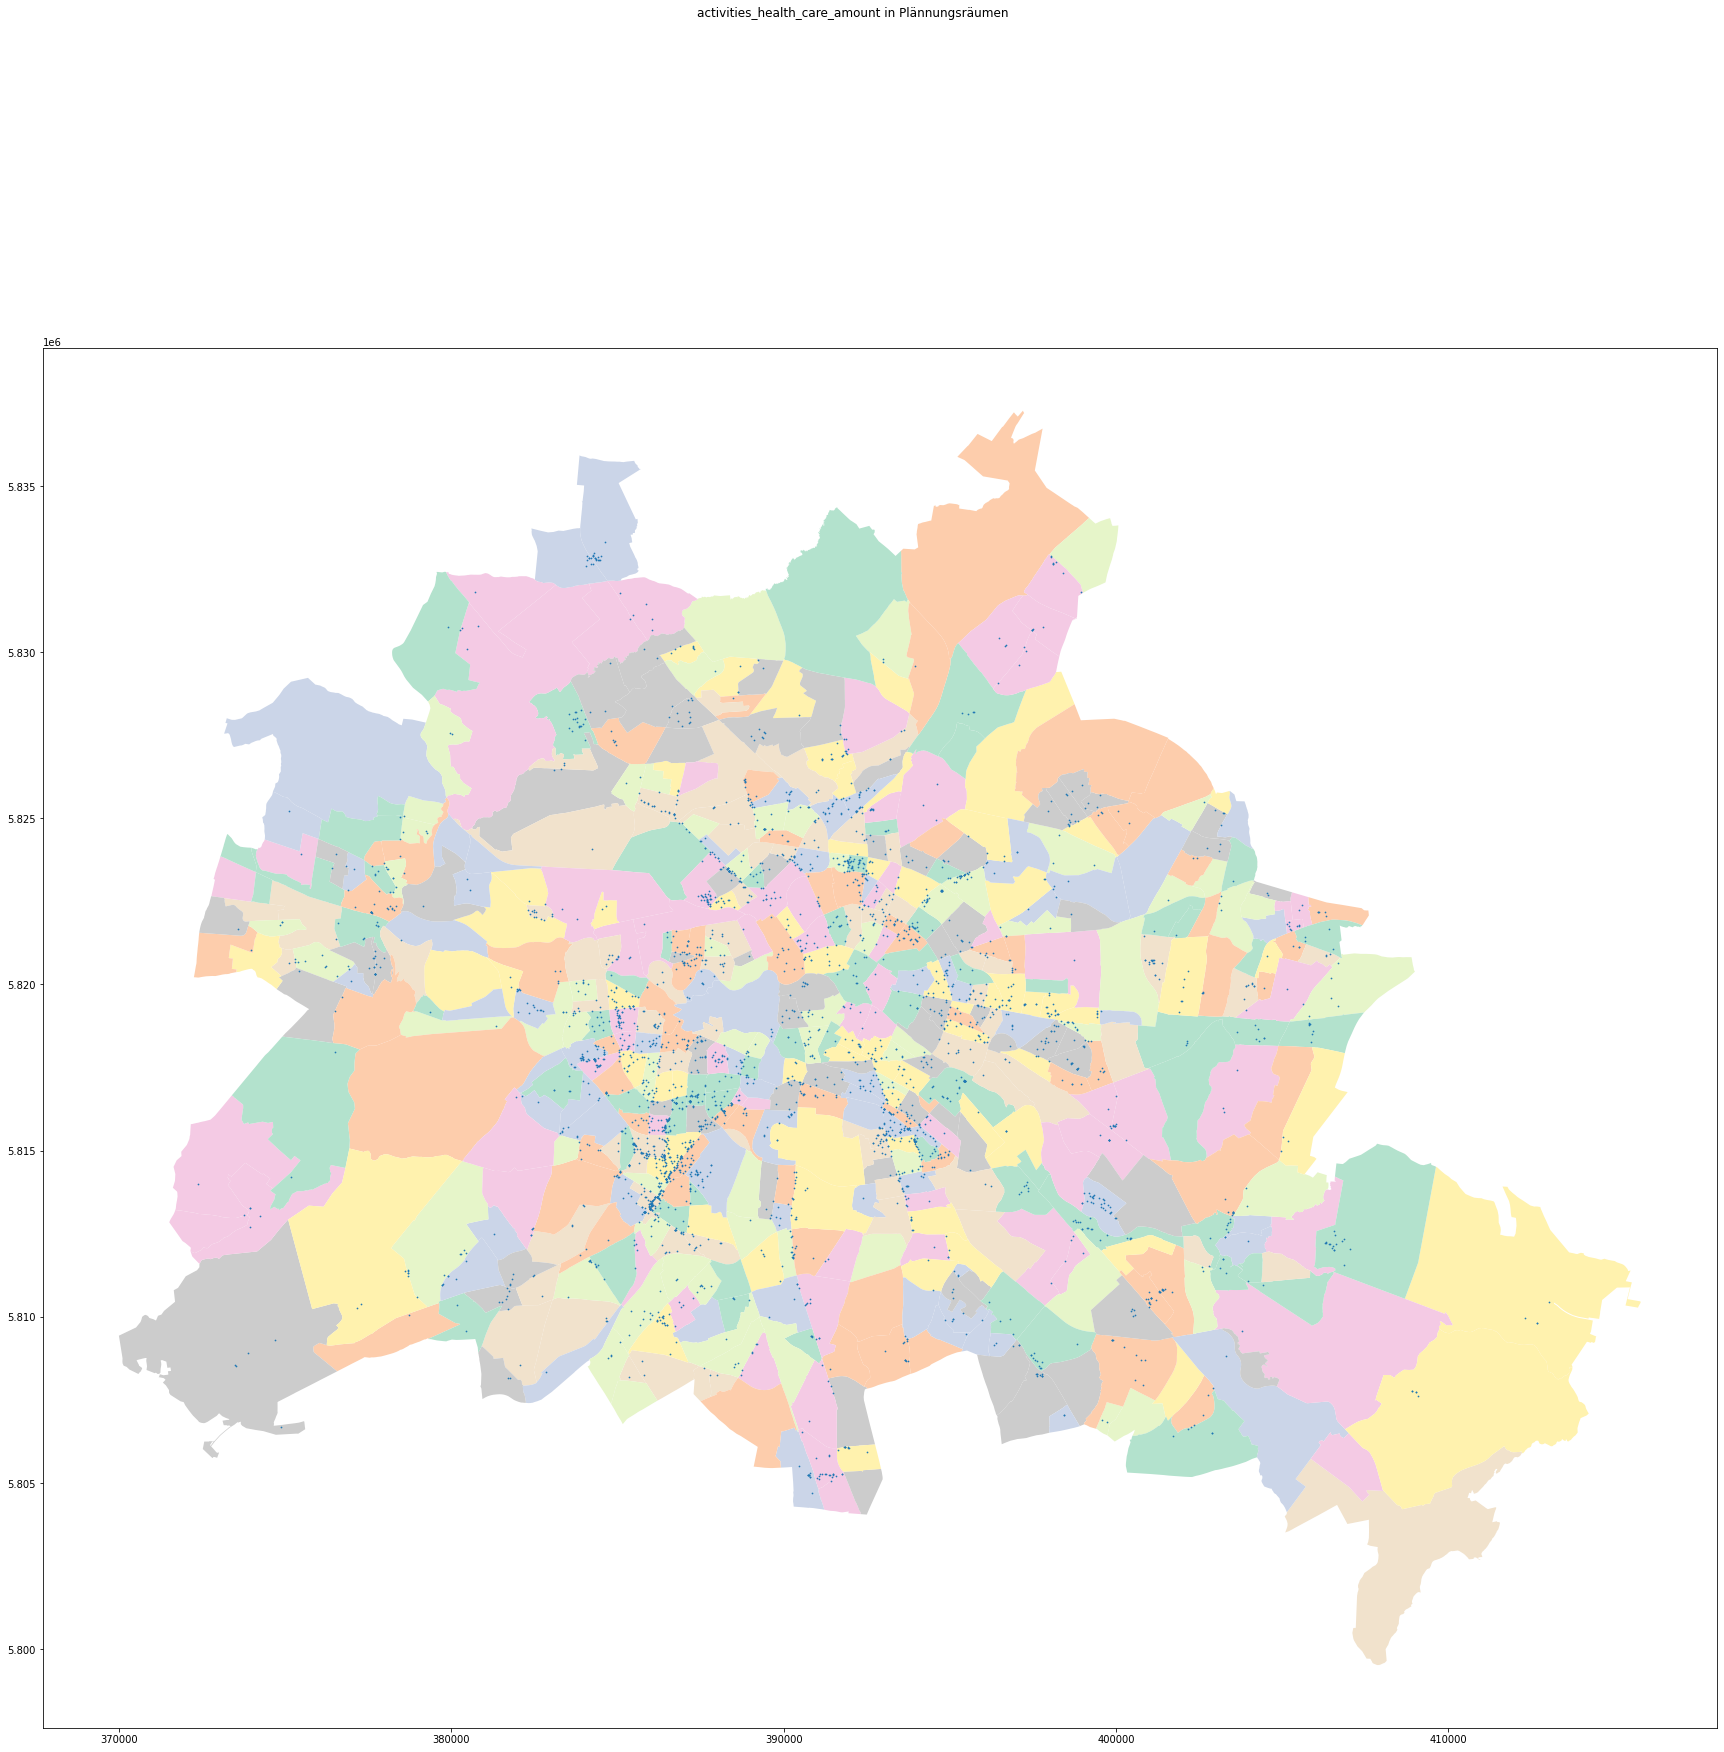

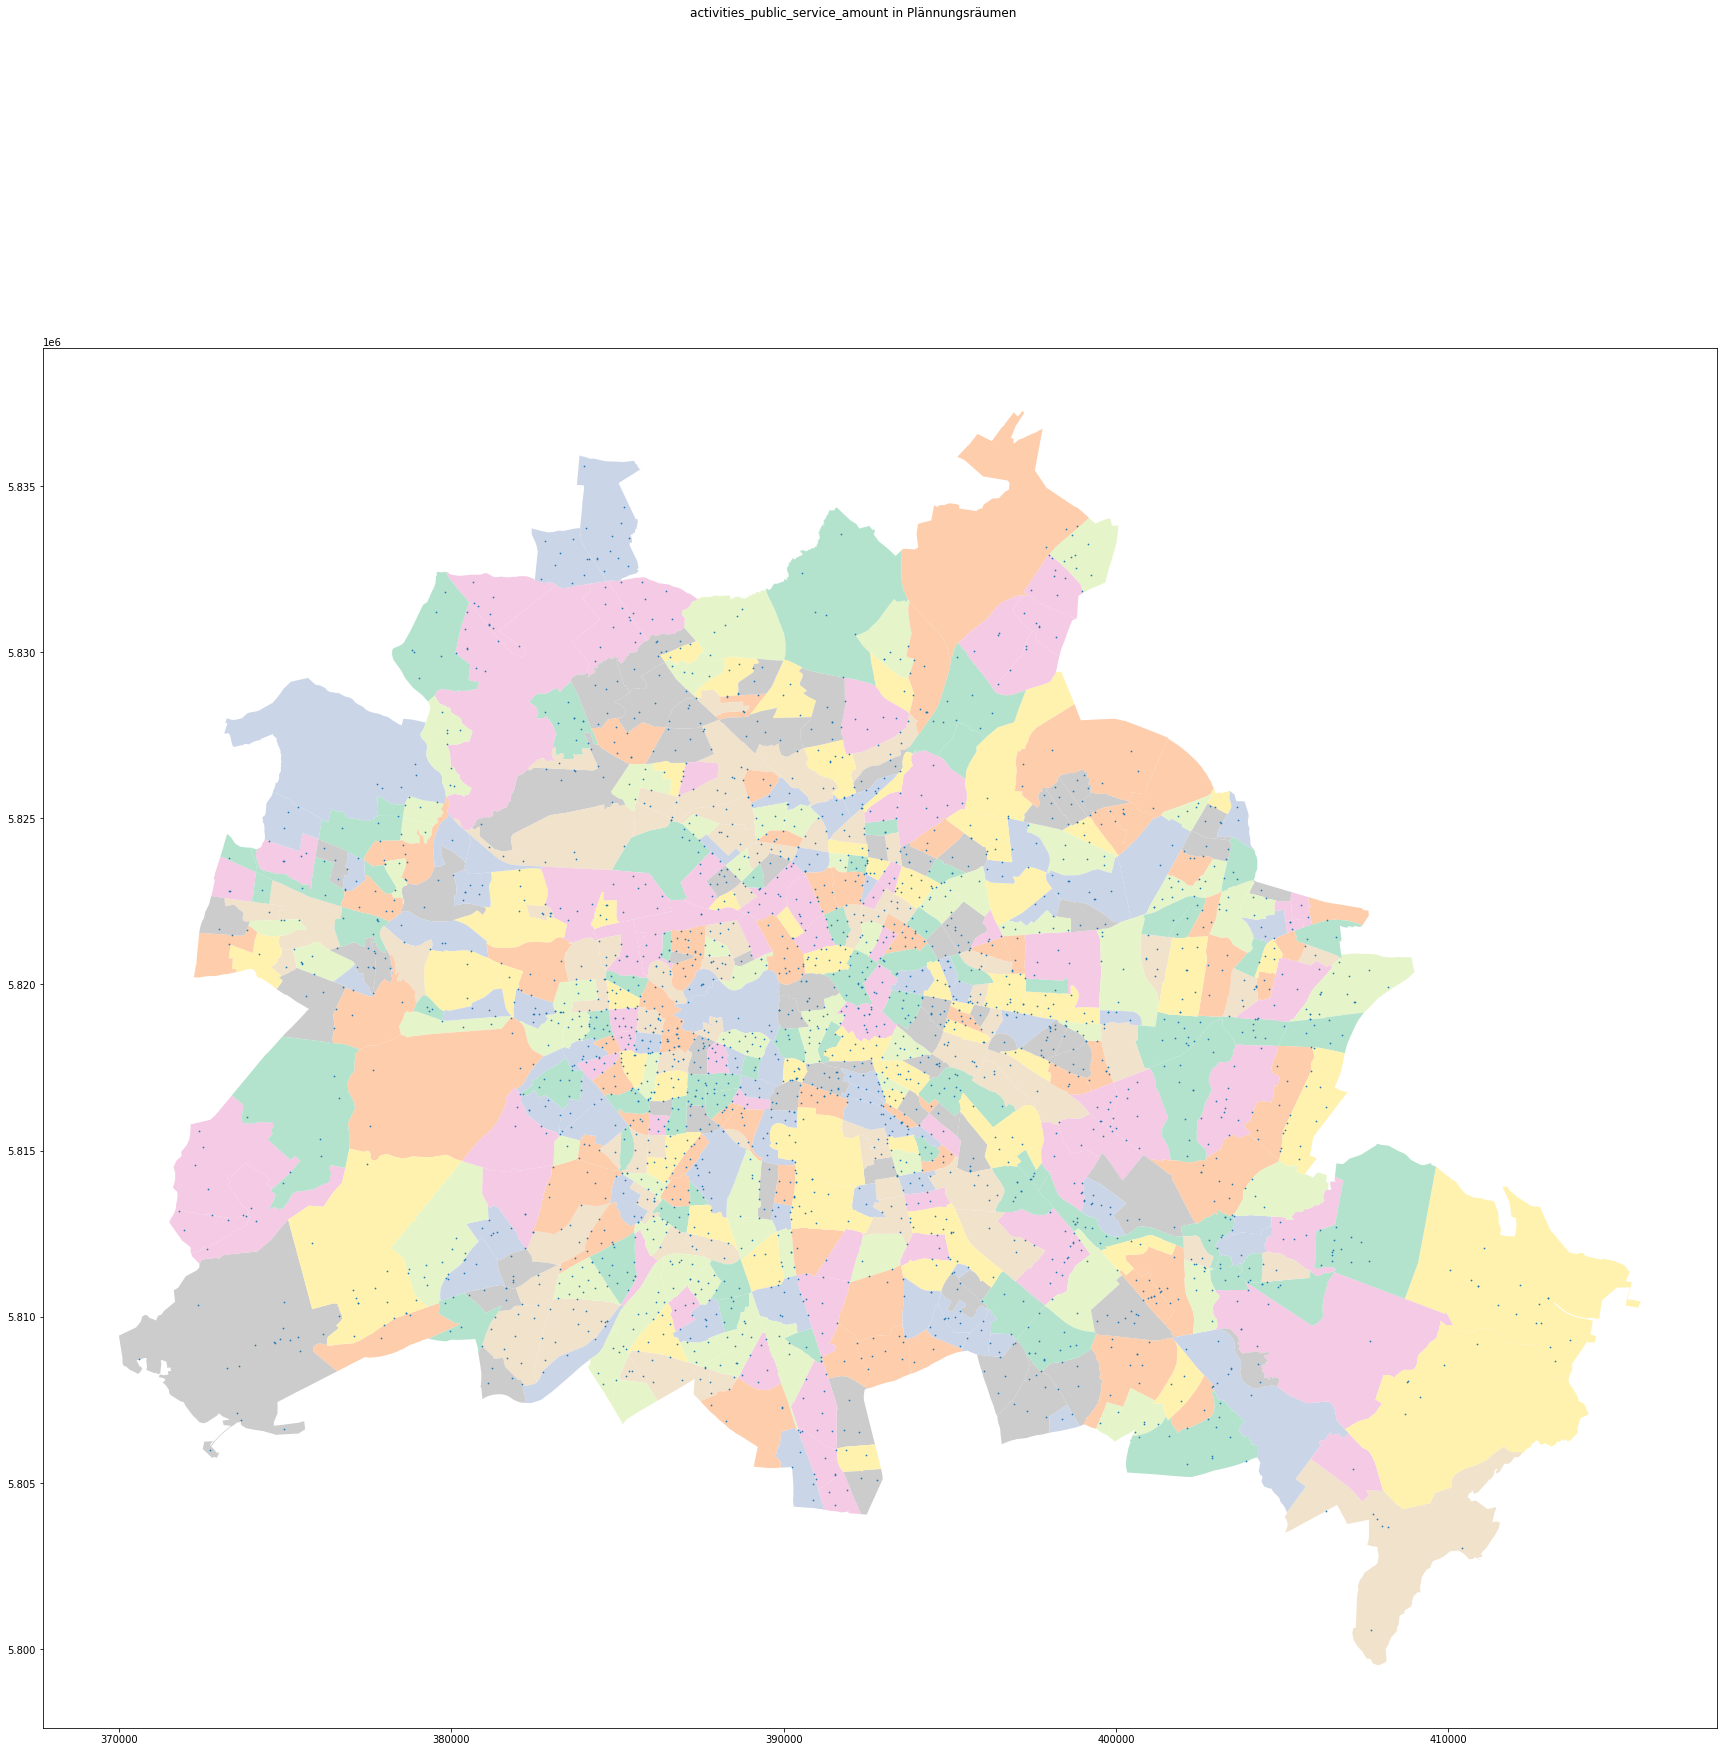

In [300]:
filenames = ["mobility_bike_infraestructure","mobility_bikepaths",
             "spaces_green","spaces_water","social_community","social_culture",
             "social_eating","social_night_life","activities_economic","activities_education",
             "activities_health_care","activities_public_service"]
for filename in filenames:
    features_plr(filename)

In [309]:
#import each features-amount per plr
df_mobility_public_transport = pd.read_csv(f"../raw_data/FeaturesOnMap/mobility_public_transport.csv").drop(columns=["Unnamed: 0"], inplace=True)
df_activities_public_service = pd.read_csv(f"../raw_data/FeaturesOnMap/activities_public_service.csv").drop(columns=["Unnamed: 0"], inplace=True)
#filenames = ["mobility_public_transport", "activities_public_service"]
#for filename in filenames:pd.read_csv(f"../raw_data/FeaturesOnMap/{filename}.csv")

In [316]:
df_activities_public_service.drop(columns=["Unnamed: 0"], inplace=True)
df_activities_public_service.head()

PLR_ID  activities_public_service_amount
0  1100101                                 4
1  1100102                                 4
2  1100103                                 7
3  1100104                                 6
4  1100205                                 7

In [357]:
pd.read_csv(f"../raw_data/FeaturesOnMap/mobility_public_transport.csv").drop(columns=["Unnamed: 0"], inplace=True)

In [220]:
nearest = df.sjoin_nearest(plr_gdf, how="left")
nearest.head()

lat        lon                      coor  \
0  52.563519  13.342294  (52.5635192, 13.3422935)   
1  52.559905  13.317087  (52.5599045, 13.3170867)   
2  52.575410  13.339278  (52.5754097, 13.3392778)   
3  52.573007  13.359576  (52.5730067, 13.3595757)   
4  52.581818  13.428768  (52.5818183, 13.4287678)   

                         geometry  index_right    PLR_ID             PLR_NAME  \
0  POINT (387636.120 5825008.266)          161  12100204           Schäfersee   
1  POINT (385918.282 5824645.794)           63  12200411  Schumacher-Quartier   
2  POINT (387462.170 5826335.446)          526  12100206       Humboldtstraße   
3  POINT (388831.468 5826036.706)          496  12100103      Breitkopfbecken   
4  POINT (393541.525 5826912.373)          266  03400724  Wolfshagener Straße   

   BZR_ID                         BZR_NAME PGR_ID           PGR_NAME BEZ  \
0  121002        Ost 2 - Alt-Reinickendorf   1210  Reinickendorf Ost  12   
1  122004  West 1 - Tegel-Süd/Flughafensee   1220              Tegel  12   
2  121002        Ost 2 - Alt-Reinickendorf   1210  Reinickendorf Ost  12   
3  121001          Ost 1 - Reginhardstraße   1210  Reinickendorf Ost  12   
4  034007                   Pankow Zentrum   0340   Südliches Pankow  03   

        FINHALT       STAND  
0  1.115710e+06  01.01.2021  
1  6.703934e+05  01.01.2021  
2  7.593227e+05  01.01.2021  
3  7.205288e+05  01.01.2021  
4  7.701117e+05  01.01.2021

In [222]:
nearest.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 15104 entries, 0 to 15108
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   lat          15104 non-null  float64 
 1   lon          15104 non-null  float64 
 2   coor         15104 non-null  object  
 3   geometry     15104 non-null  geometry
 4   index_right  15104 non-null  int64   
 5   PLR_ID       15104 non-null  object  
 6   PLR_NAME     15104 non-null  object  
 7   BZR_ID       15104 non-null  object  
 8   BZR_NAME     15104 non-null  object  
 9   PGR_ID       15104 non-null  object  
 10  PGR_NAME     15104 non-null  object  
 11  BEZ          15104 non-null  object  
 12  FINHALT      15104 non-null  float64 
 13  STAND        15104 non-null  object  
dtypes: float64(3), geometry(1), int64(1), object(9)
memory usage: 1.7+ MB


In [229]:
nearest.PLR_ID.nunique()

528

In [269]:
mob = nearest.groupby(by='PLR_ID').size().reset_index()
mob.rename(columns={0:"mobility_amount"}, inplace=True)
mob.sort_values(by = "mobility_amount")

PLR_ID  mobility_amount
413  10100103                1
188  04501151                1
138  03701659                1
135  03701555                2
335  08100310                2
..        ...              ...
5    01100206              104
149  04200311              109
140  04100101              110
9    01100310              130
269  06400735              157

[528 rows x 2 columns]

In [287]:
plr_gdf[plr_gdf["PLR_ID"] =="04200311"]

PLR_ID                  PLR_NAME  BZR_ID BZR_NAME PGR_ID  \
87  04200311  Königin-Elisabeth-Straße  042003  Westend   0420   

               PGR_NAME BEZ       FINHALT       STAND  \
87  Charlottenburg West  04  1.555820e+06  01.01.2021   

                                             geometry  
87  POLYGON ((382892.444 5818958.983, 382909.109 5...

In [134]:
def csv_to_geometry(filename):
    """Convert csv file containing lat and lon gitude columns into geodata and save in the shp file in the same directory path"""
    path = f"../raw_data/OpenStreetMaps Feature/{filename}.csv"
    df = pd.read_csv(path)
    crs = {"init": "epsg:25833"}
    geometry = [Point(xy) for xy in zip(df["lon"], df["lat"])]
    gdf = gp.GeoDataFrame(df, crs= crs, geometry= geometry)
    gdf.drop(columns=['lat', 'lon', 'coor'], inplace=True)
    #gdf.to_file(f"../raw_data/OpenStreetMaps Feature/{filename}.shp") 
    return gdf.head(5)

In [91]:
merged_df = plr_gdf.sjoin_nearest(mob_gdf, how="right")